# Calibrating the cloud clearing algorithm
The goal with the cloud clearing algorithm is to filter out areas where the cloud cover is too thick for any ice to be retrieved. This is a two-step process with multiple adjustable parameters: first all cloudy pixels are selected and added to the mask, then cloudy pixels that are likely to have visible ice are removed from the mask. Both steps use thresholds for intensity values from band 7 and band 2 of the MODIS false color imagery (7-2-1). The true color imagery can also be helpful, which includes bands 1-4-3.

Let the intensity value of band $i$ be given by $B_i$. The module then creates a binary mask with the following steps:
1. Mask all pixels with $B_7 > 110 = \tau_c$.
2. Unmask pixels with $B_7 < 200 = \tau_1$ and $B_2 > 190 = \tau_2$.
3. Unmask pixels with $B_7/B_2 < 0.75 = \tau_r$.

We evaluate the algorithm in two parts. First, we search for an optimum value for the cloud threshold $T_C$. Presently, the manual estimate of cloud fraction is our best estimate of the "truth" for the total cloud fraction $F$. The fraction of pixels with $B_7 > T_C$ is the estimated total cloud fraction $\hat{F}$. We select 2/3 of the data at random as the training dataset. To this subset, we apply $k$-fold cross validation, optimizing the choice of cloud threshold across $T_C = 0, 10, 20, \cdots, 200$. After computing RMSE for each choice of $T_C$, we find a best-fit quadratic interpolant and find the minimizing integer value of $T_C$. The optimal choice of $T_C$ is the average across the $k$ folds. We also report the mean $RMSE$ across the $k$ folds. Finally, we calculate the error in the cloud fraction relative to the remaining 1/3 of the data. 

This method performs fairly well against the manual (20% error) and the MODIS (10% error) datasets.

## Updated thoughts and planning for this part
1. It is obvious from examination of the images in "cf_mask" that a simple threshold on band 7 is not enough. It does do pretty well in some cases, but it is prone to error when there is land in the image, and when there is a mixture of ice and water pixels.
2. Based on my reading of the papers developing MODIS cloud and ice datasets, there are challenges with the cloud mask based on using a 25 km grid for sea ice cover in choosing how to apply the cloud algorithm. It uses different values for the ice and snow surfaces than for ocean and land surfaces. So direct comparison with the MODIS clouds will also have some errors.
3. As with other terms, joint measures are useful. 


In [1]:
import numpy as np
import os
import pandas as pd
import proplot as pplt
import rasterio as rio
from rasterio.plot import reshape_as_image
from sklearn.model_selection import KFold
from scipy.interpolate import interp1d

# Load the list of cloud clearing evaluation cases
dataloc = '../../eval_seg/'
df = pd.read_csv(dataloc + '/data/metadata/merged_validation_table.csv')
df['case_number'] = [str(cn).zfill(3) for cn in df['case_number']]
df.groupby('region').count()

/opt/miniconda3/envs/cal-val/lib/python3.9/site-packages/scipy/__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


case_number  start_date  center_lon  center_lat  \
region                                                                 
baffin_bay                    42          42          42          42   
barents_kara_seas             42          42          42          42   
beaufort_sea                  42          42          42          42   
bering_chukchi_seas           42          42          42          42   
east_siberian_sea             42          42          42          42   
greenland_sea                 42          42          42          42   
hudson_bay                    42          42          42          42   
laptev_sea                    42          42          42          42   
sea_of_okhostk                42          42          42          42   

                     center_x  center_y  month  sea_ice_fraction  \
region                                                             
baffin_bay                 42        42     42                42   
barents_kara_seas          42        42     42                42   
beaufort_sea               42        42     42                42   
bering_chukchi_seas        42        42     42                42   
east_siberian_sea          42        42     42                42   
greenland_sea              42        42     42                42   
hudson_bay                 42        42     42                42   
laptev_sea                 42        42     42                42   
sea_of_okhostk             42        42     42                42   

                     mean_sea_ice_concentration  init_case_number  ...  \
region                                                             ...   
baffin_bay                                   42                42  ...   
barents_kara_seas                            42                42  ...   
beaufort_sea                                 42                42  ...   
bering_chukchi_seas                          42                42  ...   
east_siberian_sea                            42                42  ...   
greenland_sea                                42                42  ...   
hudson_bay                                   42                42  ...   
laptev_sea                                   42                42  ...   
sea_of_okhostk                               42                42  ...   

                     artifacts  qa_analyst  qa_reviewer  fl_analyst  \
region                                                                
baffin_bay                  42          42           42          30   
barents_kara_seas           42          42           42          10   
beaufort_sea                42          42           42          18   
bering_chukchi_seas         42          42           42          14   
east_siberian_sea           42          42           42          12   
greenland_sea               42          42           42          22   
hudson_bay                  42          42           42          10   
laptev_sea                  42          42           42          22   
sea_of_okhostk              42          42           42          10   

                     fl_reviewer  psd_file  floe_obscuration  \
region                                                         
baffin_bay                    10        30                36   
barents_kara_seas              6        10                22   
beaufort_sea                   6        18                34   
bering_chukchi_seas            2        14                20   
east_siberian_sea              2        12                17   
greenland_sea                  4        22                32   
hudson_bay                     2        10                24   
laptev_sea                     2        22                24   
sea_of_okhostk                 0        10                13   

                     landfast_obscuration  modis_cloud_error  notes  
region                                                               
baffin_bay                           

In [2]:
df['start_date'] = pd.to_datetime(df['start_date'].values)
df.index = [cn + '_' + sat for cn, sat in zip(df.case_number, df.satellite)]

def fname(case_data, imtype='labeled_floes'):
    """Generates filenames from rows in the overview table. imtype can be 'labeled_floes', 
    'binary_floes', 'binary_landfast', or 'binary_landmask', 'truecolor', or 'falsecolor'.
    The imtype determines whether a 'png' or 'tiff' is returned.
    """

    cn = case_data['case_number']
    date = pd.to_datetime(case_data['start_date']).strftime('%Y%m%d')
    region = case_data['region']
    sat = case_data['satellite']
    if 'binary' in imtype:
        return  '-'.join([cn, region, date, sat, imtype + '.png'])
        
    elif imtype in ['truecolor', 'falsecolor', 'cloudfraction', 'landmask', 'labeled_floes',]:
        prefix = '-'.join([cn, region, '100km', date])
        return '.'.join([prefix, sat, imtype, '250m', 'tiff'])

    elif imtype in ['masie_seaice', 'masie_landmask',]:
        prefix = '-'.join([cn, region, '100km', date])
        return '.'.join([prefix, imtype.replace('_', '.'), '250m', 'tiff'])        

# Extra information needed for metadata
* Test images: add available masks to the example images.
* Using the "Threshold_CF" images, manually note when the cloud mask appears realiable and when the boundary effect is happening.
* Then we can use the land fast and ice floe images to be the "true ice" data
* Look for cases where we can find clouds past the ice edge to disqualify
* For the cloud fraction data -- our method DOES NOT APPLY to land. It will almost always flag land as cloud. So when we are doing the error analysis it needs to be aligned in that sense, the land needs to be masked out.


## Reviewing test images for cases where the cloud mask is off
* 002 - needs landfast ice mask, potentially label floes but its tricky
* 003 - needs landfast ice mask
* 005 - check alignment of the land mask and landfast ice mask
* 008 - check alignment of the land mask and landfast ice mask. Also some inconsistency with aqua and terra with the landfast ice.
* 009 - check alignment of landmask and landfast ice mask
* 011 - MODIS cloud fraction is wrong (likely edge case -- image is clear)
* 012 - consistency with floe in bottom left of Terra image. Mark as landfast
* 014 - potentially issue with modis mask -- top left looks good, if any clouds are in other sections then they are essentially transparent
* 018 - ambiguous. Possibly transparent clouds, or issue with mask. Nearly clear.
* 021 - alignment with landmask and landfast ice
* 022 - major cloud shadow effects, but cloud fraction seems decent
* 042 - full image is cloudy, the MODIS mask is incorrect
* 047 - alignment for landmask and landfast ice mask (probably for all -- need to go through and fix them)
* 059 - need landfast mask, even if no floes visible
* 061 - beautiful image
* 071 - another good example of where manual color thresholding could be used to get an ice/water mask
* 077 - MODIS mask appears agressive - possible transparent cloud or error.
* 088 - either transparent or MODIS error. Example of one where sea ice mask could be made, clouds are super thin.
* 096 - MODIS mask has a clear sky region, looks 100% cloudy to me
* 103 - are those floe labels right? doesn't look right
* 150 - bigger than usual mismatch in landmask
* 175 - MODIS mask has missing data, likely should be 100% all round
* 179 - possible edge effects, near-transparent clouds

To check the test cases, I can look at the larger region in Worldview to see if the signature of the ice edge error is there.



## Make automatic land masks from the MODIS masks and add those
It would be more consistent to have a script producing the PNG files than to do it in photoshop. I can then copy those files to photoshop to align the landfast ice masks

## Add landfast ice masks even if no floes are visible
This will let us use the landfast ice to train the cloud model.

## Potential to label ice/water for training the ice mask
This could be done image-by-image using histogram thresholding. An example where this could be effective is Case 032. Many images where the sea ice can be easily seen, but would take some work to label.

## ideas for labeling categories
CLEAR_ICE = cloud fraction < min & (landfast | sea ice floes)
CLOUD_ICE = cloud fraction > min & (landfast | sea ice floes)
CLOUD = cloud fraction > min & cloudtype = 'opaque'
CLEAR = cloud fraction < min or cloudtype = 'none'

## setting thresholds
Precision and recall for varying each parameter. Should the different cases be weighted in a particular way?

# Load data

In [3]:
# Load raster data and masks
fc_dataloc = dataloc + 'data/modis/falsecolor/'
tc_dataloc = dataloc + 'data/modis/truecolor/'
cl_dataloc = dataloc + 'data/modis/cloudfraction/'

lm_dataloc = dataloc + 'data/validation_images/binary_landmask/'
lb_dataloc = dataloc + 'data/validation_images/binary_floes/'
lf_dataloc = dataloc + 'data/validation_images/binary_landfast/'

masie_ice_loc = dataloc + 'data/masie/masie_ice/'
masie_land_loc = dataloc + 'data/masie/masie_land/'

tc_images = {}
fc_images = {}
cl_images = {}
lb_images = {}
lf_images = {}
lm_images = {}
mi_images = {}
ml_images = {}

missing = []
for row, data in df.iterrows():
    
    for datadir, imtype, data_dict in zip([tc_dataloc, fc_dataloc, cl_dataloc, lb_dataloc, lf_dataloc, lm_dataloc, masie_ice_loc, masie_land_loc],
                                          ['truecolor', 'falsecolor', 'cloudfraction', 'binary_floes',
                                           'binary_landfast', 'binary_landmask', 'masie_seaice', 'masie_landmask'],
                                          [tc_images, fc_images, cl_images, lb_images, lf_images, lm_images, mi_images, ml_images]):
        try:
            with rio.open(datadir + fname(df.loc[row,:], imtype)) as im:
                data_dict[row] = im.read()
        except:
            if imtype in ['falsecolor', 'cloudfraction', 'landmask']:
                print('Couldn\'t read', fname(df.loc[row,:], imtype), imtype)
            elif imtype == 'binary_floes':
                if df.loc[row, 'visible_floes'] == 'yes':
                    missing.append(fname(df.loc[row,:], imtype))
            elif imtype == 'binary_landfast':
                if df.loc[row, 'visible_landfast_ice'] == 'yes':
                    missing.append(fname(df.loc[row,:], imtype))
            elif 'masie' in imtype:
                missing.append(fname(df.loc[row,:], imtype))

/opt/miniconda3/envs/cal-val/lib/python3.9/site-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


In [4]:
cf_images = {}
cases = [c for c in cl_images]
cases.sort()

# Make the index of the df a unique case label
df.index = [x.case_number + '_' + x.satellite for row, x in df.iterrows()]

# Loading from file
cf_images = {}
for case in df.index:
    file = fname(df.loc[case], 'binary_landmask').replace('binary_landmask.png', 'cloudfraction.csv')
    try:
        cf_images[case] = pd.read_csv("../data/cloudfraction_numeric/" + file, index_col=0) 
        cf_images[case].index = cf_images[case].index.astype(int)
        cf_images[case].columns = cf_images[case].columns.astype(int)
    except:
        print(case)

df['cloud_fraction_modis'] = np.nan
for case in cf_images:
    df.loc[case, 'cloud_fraction_modis'] = np.mean(cf_images[case]/100)

# Visualize dataset
* TC, FC, Cloud Fraction
* Default Mask, MASIE, Manual labeling

In [163]:
import warnings
warnings.simplefilter("ignore")
T1 = 190
T2 = 200
R_lower = 0
R_upper = 0.75
tc = 110

def generate_masks(fc_image, t1, t2, r_lower, r_upper, tc):
    """Generate the all-cloud and opaque-cloud masks. Opaque cloud mask is defined as a subset
    of the all-cloud mask where the ice floes are visible."""
    b7 = fc_image[0,:,:]
    b2 = fc_image[1,:,:]

    clouds_view = b7 > tc # true == cloudy pixel
    mask_b7b2 = (b7 < t1) & (b2 > t2) # true == thin cloud
    mask_ratio = b7/b2
    mask_cloud_ice = (mask_ratio > r_lower) & (mask_ratio < r_upper)
    mask_cloud_ice = mask_cloud_ice & mask_b7b2
    cloud_mask = ~(mask_cloud_ice | ~clouds_view)
    return clouds_view, cloud_mask
    
for case in fc_images:
    region = df.loc[case,'region']
    cf_manual = (df.loc[case, 'cloud_fraction_manual']*100).round(0)
    cf_modis = (df.loc[case, 'cloud_fraction_modis']*100).round(0)
    
    fig, axs = pplt.subplots(ncols=3, nrows=2)
    
    # first few images have a single array
    clouds_view, cloud_mask = generate_masks(fc_images[case], t1=T1, t2=T2, r_lower=0, r_upper=R_upper, tc=tc)
    layered_mask = ((cloud_mask).astype(float) + clouds_view.astype(float))/2
    for ax, data, title in zip(axs, 
                    [tc_images[case], fc_images[case], cf_images[case], layered_mask],
                    ['TC Image', 'FC Image', 'Cloud Fraction (%)', 'Default Cloud Mask']):
        if title in ['TC Image', 'FC Image']:
            ax.imshow(reshape_as_image(data))
        elif title == 'Cloud Fraction (%)':
            c = ax.pcolormesh(data.values, vmin=0, vmax=100, N=17, cmap='Blues')
            ax.colorbar(c, label='Cloud Fraction (%)')
            ax.format(urtitle='Manual: {c0}%\nModis: {c1}'.format(c0=cf_manual, c1=cf_modis))
        else:
            c = ax.pcolormesh(data, N=3, cmap='blues')
            ax.colorbar(c, ticks=[.2, 0.6, 1], loc='b', alpha=1, ticklabels=['Clear', 'Unmask', 'Mask'], ticklen=0.1)
        ax.format(title=title, yreverse=True)
    
    # plot MASIE data
    ax = axs[1, 1]
    masie_ice = mi_images[case].squeeze()
    masie_land = ml_images[case].squeeze()
    ax.imshow(np.ma.masked_array(masie_land, mask=masie_land != 1), c='steelblue')
    ax.imshow(np.ma.masked_array(masie_ice, mask=masie_ice==0), c='w')
    ax.imshow(np.ma.masked_array(masie_land, mask=masie_land != 2), c='gray')
    ax.imshow(np.ma.masked_array(masie_land, mask=masie_land != 4), c='darkgray')
    h = []
    for c in ['steelblue', 'w', 'lightgray', 'darkgray']:
        h.append(ax.plot([],[],m='s', lw=0, c=c, edgecolor='k'))
    ax.legend(h, ['Water', 'Ice', 'Coast', 'Land'], loc='b', ncols=2)
    ax.format(title='MASIE')
    
    
    # plot manual label data
    ax = axs[1, 2]
    binary_land = lm_images[case][0,:,:]
    clouds25 = (cf_images[case] >= 25).astype(int)
    clouds50 = (cf_images[case] >= 50).astype(int)
    clouds = (clouds25 + clouds50)/2
    
    ax.imshow(np.ma.masked_array(binary_land, mask=binary_land == 0), c='gray9')
    if case in lb_images:
        manual_ice = lb_images[case][0,:,:]
        ax.imshow(np.ma.masked_array(manual_ice, mask=manual_ice==0), c='red5')
    else:
        ax.format(ultitle='No ice mask')
        
    if case in lf_images:
        manual_landfast = lf_images[case][0,:,:]
        ax.imshow(np.ma.masked_array(manual_landfast, mask=manual_landfast == 0), c='yellow4')
    else:
        ax.format(urtitle='No landfast mask')

    ax.imshow(np.ma.masked_array(clouds, mask=clouds==0), cmap='Blues', vmin=0, vmax=2, alpha=0.5)
        
    h = []
    for c in ['red5', 'yellow4', 'darkgray', 'lightblue']:
        h.append(ax.plot([],[],m='s', lw=0, c=c, edgecolor='k'))
    ax.legend(h, ['Sea Ice', 'Landfast Ice', 'Land', 'MODIS cloud'], loc='b', ncols=2)
    ax.format(title='Manual labels')
    
    axs.format(yreverse=True, suptitle=case.replace('_', ' ') + ' ' + region.replace('_', ' ').title())
    fig.save('../figures/overview_images/' + case + '_' + region + '_overview.png', dpi=300)
    pplt.close(fig)

# Validation against the manual estimate of cloud fraction
The current version that I've described in the paper uses the cloud fraction across the whole image. This does not tell us the spatial mismatch, though. To do that, I'll need to set up a function that gets the 5 km resolution cloud fractions from the IFT estimate.

Basically: for the modis data, I can subsample every 5 km (every 20th pixel center). For the IFT data, I do a mean with reshaping

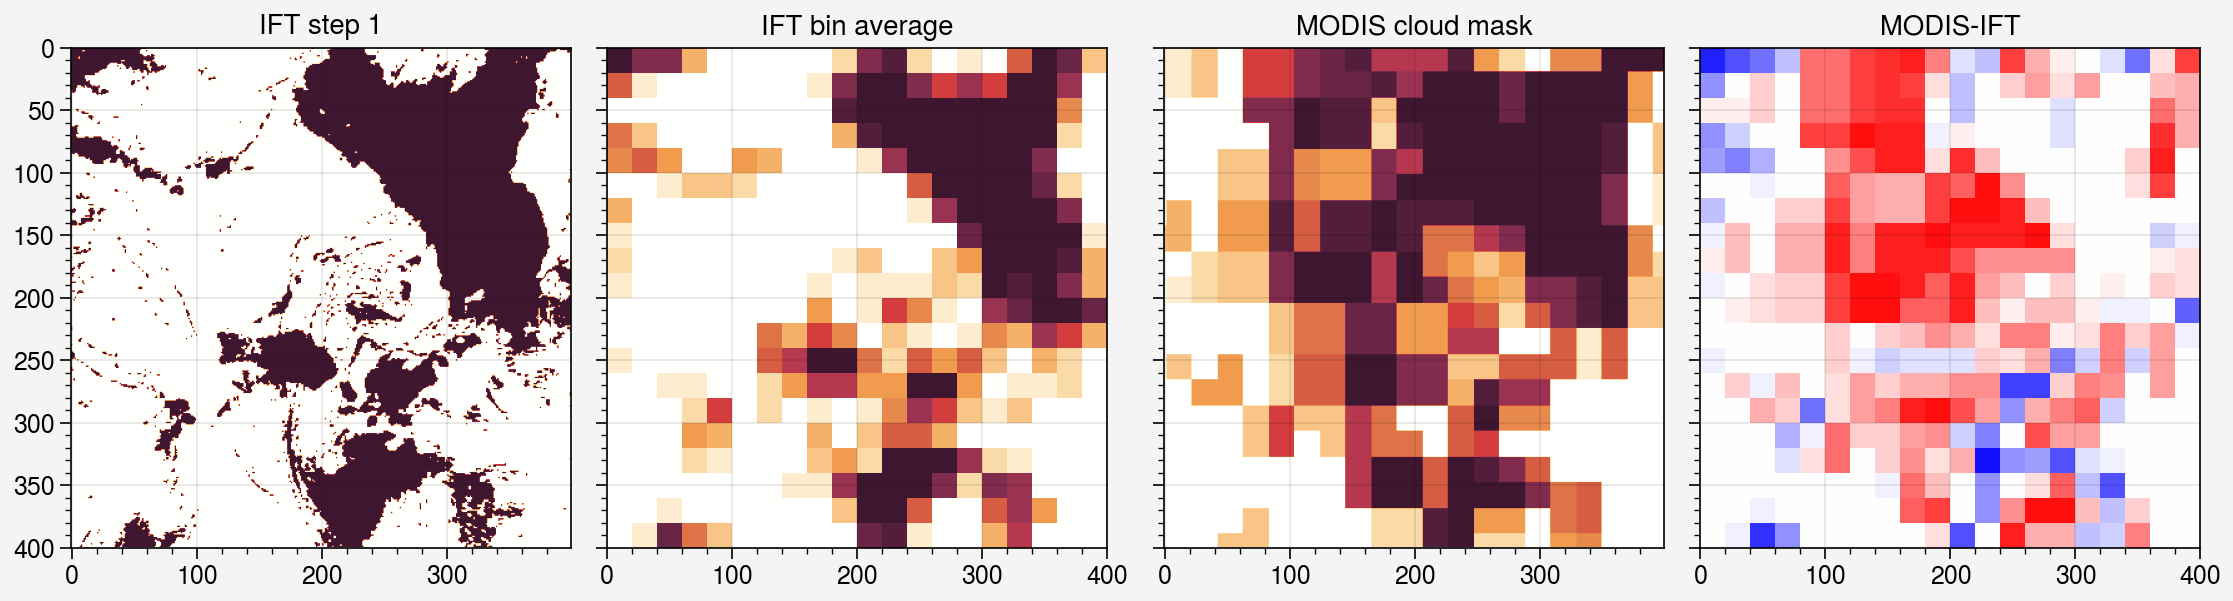

In [9]:
# assumes A is square! and that 20 evenly divdes the shape
ift_est = fc_images[case][0,:,:] > 26
A = ift_est.astype(int)
n = A.shape[0]
m = int(n/20)
# reshapes to dimension (80, 20, 80, 20)
Amean = A.reshape([m, n//m, m, n//m]).mean(3).mean(1)
bin_edges = np.linspace(0, 100, 17)
bin_centers = 0.5*(bin_edges[1:] + bin_edges[:-1])

ift_vec = np.ravel(Amean*100)
ift_dig = np.digitize(ift_vec, bin_edges) - 1 # Digitize puts 0 if less than the lowest bin, so you have to subtract.
ift_dig[ift_dig == 16] = 15 # Put values of exactly 100 into the highest bin
binned_ift = np.reshape(bin_centers[ift_dig], Amean.shape)


fig, ax = pplt.subplots(ncols=4)
ax[0].imshow(A)
ax[1].imshow(binned_ift, extent=[0, 400, 400, 0])
ax[2].imshow(cf_images[case])
ax[3].imshow(cf_images[case].values[::20, ::20] - binned_ift, vmin=-100, vmax=100, cmap='bwr',
            extent=[0, 400, 400, 0])
ax[0].format(title='IFT step 1')
ax[1].format(title='IFT bin average')
ax[2].format(title='MODIS cloud mask')
ax[3].format(title='MODIS-IFT')

In [10]:
np.unique(cf_images[case])

array([ 3.125,  9.375, 15.625, 21.875, 28.125, 34.375, 40.625, 46.875,
       53.125, 59.375, 65.625, 71.875, 78.125, 84.375, 90.625, 96.875])

## Comparison against manual cloud fraction
Since the manual cloud fraction is 1D, we are limited to the comparison between image-wide cloud fractions. That's what is calculated here.

In [11]:
# Compute estimated cloud fraction for a range of threshold values
cloud_cases = df.dropna(subset='cloud_fraction_manual').index
TC = np.linspace(0, 200, 21)
df_est_tc = pd.DataFrame(index=cloud_cases,
                          columns=TC, data=np.nan)

# for each value, compute an estimated cloud fraction based on the fc_images
for tc in df_est_tc.columns:
    for case in df_est_tc.index:
        if case in fc_images:
            df_est_tc.loc[case, tc] = np.mean(fc_images[case][0,:,:] > tc)

# finally, calculate the difference between F and F_est
df_err = (df_est_tc.T - df.loc[cloud_cases, 'cloud_fraction_manual']).T

df_training = df_err.sample(frac=2/3, replace=False, random_state=306)
df_testing = df_err.loc[[x for x in df_err.index if x not in df_training.index]]

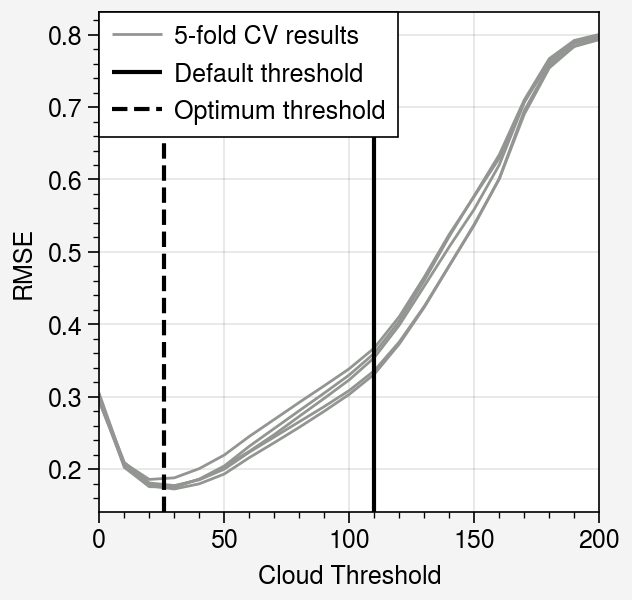

In [12]:
# Test version without splitting by regions to get syntax
fig, ax = pplt.subplots()
x_eval = np.linspace(TC.min(), TC.max(), 201)
results = []

# Initialize cross validation
# TBD: learn how to stratify within the K-fold samplng
kf = KFold(n_splits=5, random_state=20240126, shuffle=True)

for i, (train_index, test_index) in enumerate(kf.split(df_training)):
    # first get the root mean square error as a function of TC
    rmse = np.sqrt(np.mean( df_training.iloc[train_index,:]**2, axis=0))
    
    # then find the minimum
    tc_optimal = pd.Series(interp1d(x=rmse.index, y=rmse.values, kind='quadratic')(x_eval), index=x_eval).idxmin()

    test_cases = df_training.iloc[test_index, :].index
    test_results = np.array([
        np.mean(fc_images[case][0,:,:] > tc_optimal) - df.loc[case, 'cloud_fraction_manual']
            for case in test_cases if case in fc_images])
    tc_rmse = np.sqrt(np.mean(test_results**2))
    results.append([tc_optimal, tc_rmse])
    
    ax.plot(rmse, label='', color='gray', lw=1) #label='k=' + str(i))
ax.plot([],[], color='gray', lw=1, label='5-fold CV results')
kfold_results = pd.DataFrame(results, columns=['TC', 'RMSE']).mean(axis=0).round(2)

ax.axvline(110, color='k', label='Default threshold')
ax.axvline(kfold_results['TC'], color='k', ls='--', label='Optimum threshold')
ax.format(ylabel='RMSE', xlabel='Cloud Threshold')
ax.legend(loc='ul', ncols=1, alpha=1)

# fig.save('../figures/cloud_fraction_calibration_manual.png', dpi=300)

In [13]:
kfold_results = pd.DataFrame(results, columns=['TC', 'RMSE'])
print('Cross validation results')
print(kfold_results.round(2))
print("\n")

TC, RMSE = kfold_results.mean(axis=0).round(2)
print('Training data')
print("Cloud threshold: ", int(TC))
print("RMSE (%): ", 100*RMSE)
print("\n")
# Error against the held-out data
tc = TC
test_results = np.array([
    np.mean(fc_images[case][0,:,:] > tc) - df.loc[case, 'cloud_fraction_manual']
        for case in df_testing.index if case in fc_images])
test_results = pd.Series(test_results, index=[case for case in df_testing.index if case in fc_images])
tc_rmse = np.sqrt(np.mean(test_results**2))
print('Comparison against test data')
print('RMSE:', np.round(tc_rmse, 3))

Cross validation results
     TC  RMSE
0  27.0  0.18
1  25.0  0.19
2  28.0  0.20
3  27.0  0.18
4  23.0  0.14


Training data
Cloud threshold:  26
RMSE (%):  18.0


Comparison against test data
RMSE: 0.22


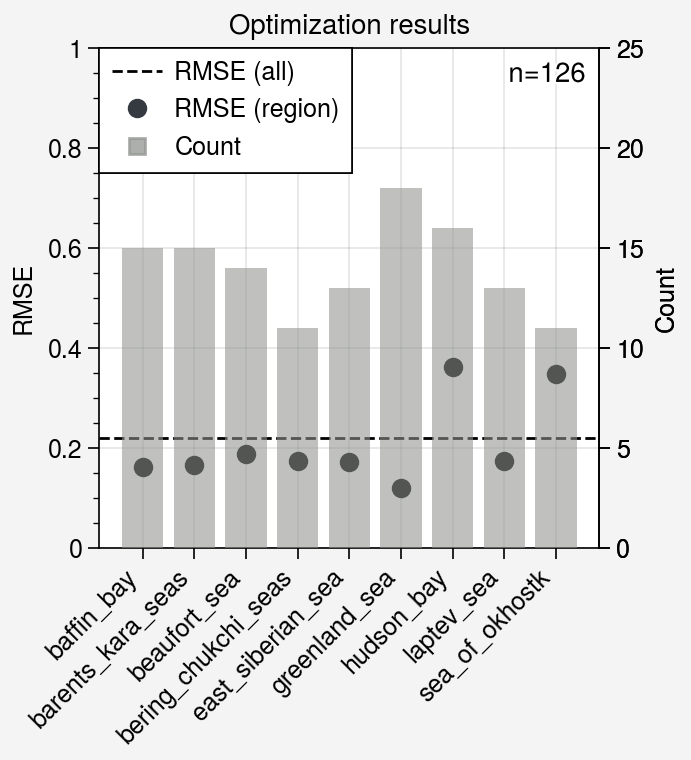

In [14]:
fig, ax = pplt.subplots()
ax.plot(
    test_results.groupby(df.loc[test_results.index, 'region']).apply(lambda x: np.sqrt(np.mean(x**2))),
    marker='o', lw=0, zorder=2, color='k')
ax.axhline(tc_rmse, color='k', ls='--', lw=1)
ax2 = ax.twinx()
ax2.bar(
    test_results.groupby(df.loc[test_results.index, 'region']).count(), zorder=0, color='gray', alpha=0.35
    )
ax2.format(ylabel='Count', ytickminor=False)

ax.format(xrotation=45, ylim=(0, 1), xlabel='', ylabel='RMSE', title='Optimization results')
ax.format(urtitle='n=' + str(len(test_results)))
ax2.format(ylim=(0, 25))
h = [ax.plot([],[],marker='', ls='--', color='k', lw=1),
     ax.plot([],[],marker='o', color='gray8', lw=0),
     ax.plot([],[],marker='s', color='gray', alpha=0.75, lw=0)]
ax2.legend(h, ['RMSE (all)', 'RMSE (region)', 'Count'], loc='ul', ncols=1, alpha=1)
# fig.save('../figures/cloud_fraction_validation_manual.png', dpi=300)

## Comparison with MODIS cloud fraction (spatial resolving)
For each case, we compute the binned cloud fraction, matching the MODIS cloud fraction bins. Then we compute the mean square error between the two images.

In [15]:
def get_binned_ift_est(fc, tc_threshold):
    """Computes a 5 km average of the IFT data and bins it into the
    same resolution as the MODIS cloud fraction data."""
    ift_est = fc > tc_threshold
    
    A = ift_est.astype(int)
    n = A.shape[0]
    m = int(n/20)
    
    # reshapes to dimension (80, 20, 80, 20)
    Amean = A.reshape([m, n//m, m, n//m]).mean(3).mean(1)
    
    bin_edges = np.linspace(0, 100, 17)
    bin_centers = 0.5*(bin_edges[1:] + bin_edges[:-1])
    
    ift_vec = np.ravel(Amean*100)
    ift_dig = np.digitize(ift_vec, bin_edges) - 1 # Digitize puts 0 if less than the lowest bin, so you have to subtract.
    ift_dig[ift_dig == 16] = 15 # Put values of exactly 100 into the highest bin
    binned_ift = np.reshape(bin_centers[ift_dig], Amean.shape)

    return binned_ift


In [16]:
# Compute estimated cloud fraction for a range of threshold values
cloud_cases = df.index
TC = np.linspace(0, 200, 21)
df_err = pd.DataFrame(index=cloud_cases,
                          columns=TC, data=np.nan)

# for each value, compute an estimated cloud fraction based on the fc_images
for tc in df_est_tc.columns:
    for case in df_est_tc.index:
        if case in fc_images:
            ift_est = get_binned_ift_est(fc_images[case][0,:,:], tc)
            mod_est = cf_images[case].values[::20,::20]
            
            df_err.loc[case, tc] = np.sqrt(np.mean((ift_est - mod_est)**2))

df_training = df_err.sample(frac=2/3, replace=False, random_state=306)
df_testing = df_err.loc[[x for x in df_err.index if x not in df_training.index]]

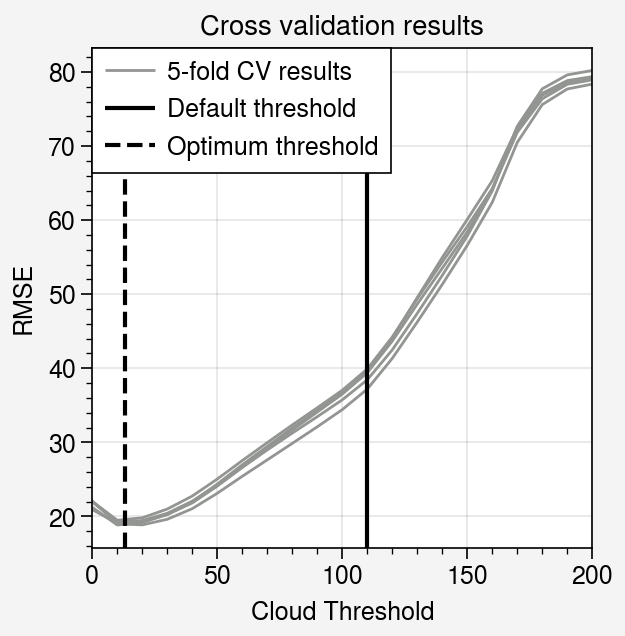

In [17]:
# Test version without splitting by regions to get syntax
fig, ax = pplt.subplots()
x_eval = np.linspace(TC.min(), TC.max(), 201)
results = []

# Initialize cross validation
# TBD: learn how to stratify within the K-fold samplng
kf = KFold(n_splits=5, random_state=20240126, shuffle=True)

for i, (train_index, test_index) in enumerate(kf.split(df_training)):
    # first get the root mean square error as a function of TC
    rmse = np.mean(df_training.iloc[train_index,:], axis=0)
    
    # then find the minimum
    tc_optimal = pd.Series(interp1d(x=rmse.index, y=rmse.values, kind='quadratic')(x_eval), index=x_eval).idxmin()

    test_cases = df_training.iloc[test_index, :].index
    test_results = np.array([
        np.mean(fc_images[case][0,:,:] > tc_optimal) - df.loc[case, 'cloud_fraction_manual']
            for case in test_cases if case in fc_images])
    tc_rmse = np.sqrt(np.mean(test_results**2))
    results.append([tc_optimal, tc_rmse])
    
    ax.plot(rmse, label='', color='gray', lw=1) #label='k=' + str(i))
ax.plot([],[], color='gray', lw=1, label='5-fold CV results')
kfold_results = pd.DataFrame(results, columns=['TC', 'RMSE']).mean(axis=0).round(2)

ax.axvline(110, color='k', label='Default threshold')
ax.axvline(kfold_results['TC'], color='k', ls='--', label='Optimum threshold')
ax.format(ylabel='RMSE', xlabel='Cloud Threshold', title='Cross validation results')
ax.legend(loc='ul', ncols=1, alpha=1)
fig.save('../figures/cloud_fraction_step1_calibration_modis.png', dpi=300)

In [18]:
kfold_results = pd.DataFrame(results, columns=['TC', 'RMSE'])
print('Cross validation results')
print(kfold_results.round(2))
print("\n")

TC, RMSE = kfold_results.mean(axis=0).round(2)
print('Training data')
print("Cloud threshold: ", int(TC))
print("RMSE (%): ", 100*RMSE)
print("\n")
# Error against the held-out data
tc = TC
test_results = np.array([np.sqrt(np.mean((get_binned_ift_est(fc_images[case][0,:,:], tc) - \
                                          cf_images[case].values[::20,::20])**2))
                         for case in df_testing.index if case in fc_images])
test_results = pd.Series(test_results, index=[case for case in df_testing.index if case in fc_images])
print('Comparison against test data')
print('RMSE (%):', test_results.mean().round(2))

Cross validation results
     TC  RMSE
0  13.0  0.18
1  13.0  0.21
2  14.0  0.20
3  13.0  0.20
4  13.0  0.18


Training data
Cloud threshold:  13
RMSE (%):  19.0


Comparison against test data
RMSE (%): 21.46


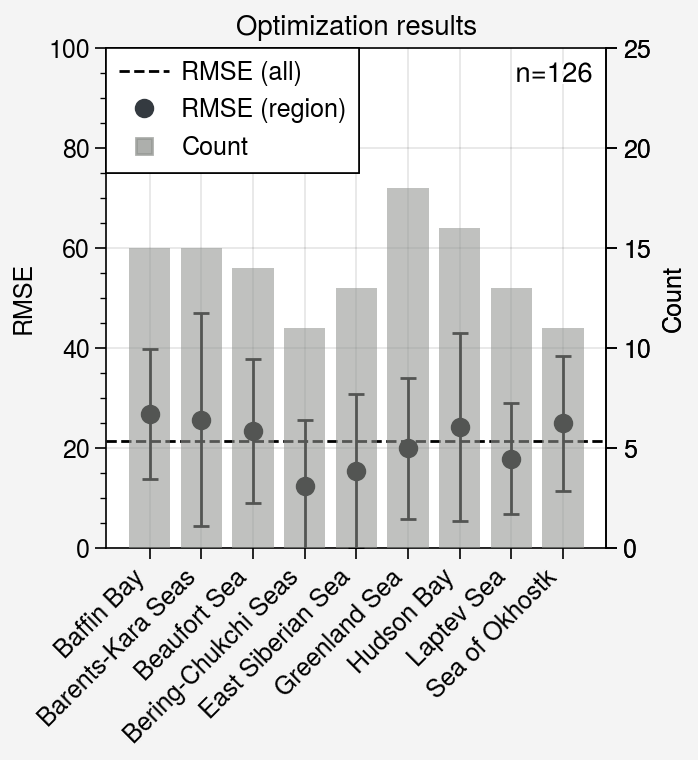

In [19]:
fig, ax = pplt.subplots()
mean_rmse = test_results.groupby(df.loc[test_results.index, 'region']).mean()
stdev_rmse = test_results.groupby(df.loc[test_results.index, 'region']).std() 
ax.errorbar(x=np.arange(len(mean_rmse)),
    y=mean_rmse.values,
    yerr = stdev_rmse.values,
    marker='o', lw=0, zorder=2, color='k', elinewidth=1)
ax.axhline(test_results.mean(), color='k', ls='--', lw=1)
ax2 = ax.twinx()
region_counts = test_results.groupby(df.loc[test_results.index, 'region']).count()
newnames = [c.replace('_', ' ').title() for c in region_counts.index]
for idx in range(len(newnames)):
    if newnames[idx] == 'Barents Kara Seas':
        newnames[idx] = 'Barents-Kara Seas'
    elif newnames[idx] == 'Bering Chukchi Seas':
        newnames[idx] = 'Bering-Chukchi Seas'
    elif newnames[idx] == 'Sea Of Okhostk':
        newnames[idx] = 'Sea of Okhostk'
region_counts.index = newnames

ax2.bar(region_counts, zorder=0, color='gray', alpha=0.35
    )
ax2.format(ylabel='Count', ytickminor=False)

ax.format(xrotation=45, ylim=(0, 100), xlabel='', ylabel='RMSE', title='Optimization results')
ax.format(urtitle='n=' + str(len(test_results)))
ax2.format(ylim=(0, 25))
h = [ax.plot([],[],marker='', ls='--', color='k', lw=1),
     ax.plot([],[],marker='o', color='gray8', lw=0),
     ax.plot([],[],marker='s', color='gray', alpha=0.75, lw=0)]
ax2.legend(h, ['RMSE (all)', 'RMSE (region)', 'Count'], loc='ul', ncols=1, alpha=1)
fig.save('../figures/cloud_fraction_step1_validation_modis.png', dpi=300)

The MODIS cloud mask is designed to work well for the full Earth. It contains methods for adapting the modeled surface reflectance for snow and ice surfaces. It often does very well. We examined the cloud fraction in the images manually as well as using the MODIS cloud product. Most sea ice regions are pack ice (MIZ is a small fraction of the total sea ice area). Since ocean and ice are treated differently in the model used for the cloud fraction, it is not surprising that there are errors at the MIZ-ocean interface. Case 11 is a good example of this: the cloud mask is clearly highlighting regions of sea ice.

# Plot scatter plot of manual vs MODIS cloud fraction

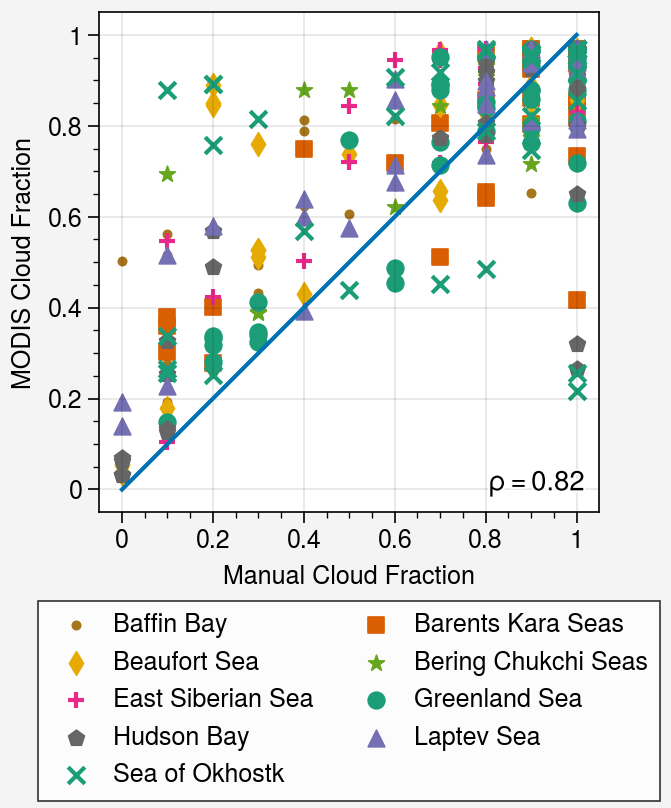

In [20]:
regions = pd.read_csv(dataloc + '/data/metadata/region_definitions.csv', index_col=0)

colors = {region: c['color'] for region, c in zip(
            regions.index,
            pplt.Cycle('dark2', len(regions)))}
markerstyles = {region: ls for region, ls in zip(regions.index,
                        ['o', 's', '^', '+', '*', 'd', '.', 'p', 'x'])}

regions['print_title'] = [c.replace('_', ' ').title().replace('Of', 'of') for c in regions.index]
regions = regions.sort_values('center_lon')


fig, ax = pplt.subplots()
for region, group in df.groupby('region'):
    
    ax.scatter(group['cloud_fraction_manual'], group['cloud_fraction_modis'], label=regions.loc[region, 'print_title'],
               m=markerstyles[region], color=colors[region])
ax.legend(loc='b', ncols=2)
ax.plot([0, 1], [0, 1])
ax.format(ylim=(-0.05, 1.05), xlim=(-0.05, 1.05), xlabel='Manual Cloud Fraction', ylabel='MODIS Cloud Fraction')
ax.format(lrtitle='$\\rho=$' + str(np.round(df['cloud_fraction_modis'].corr(df['cloud_fraction_manual']), 2)))
fig.save('../figures/manual_modis_cloud_comparison.png', dpi=300)

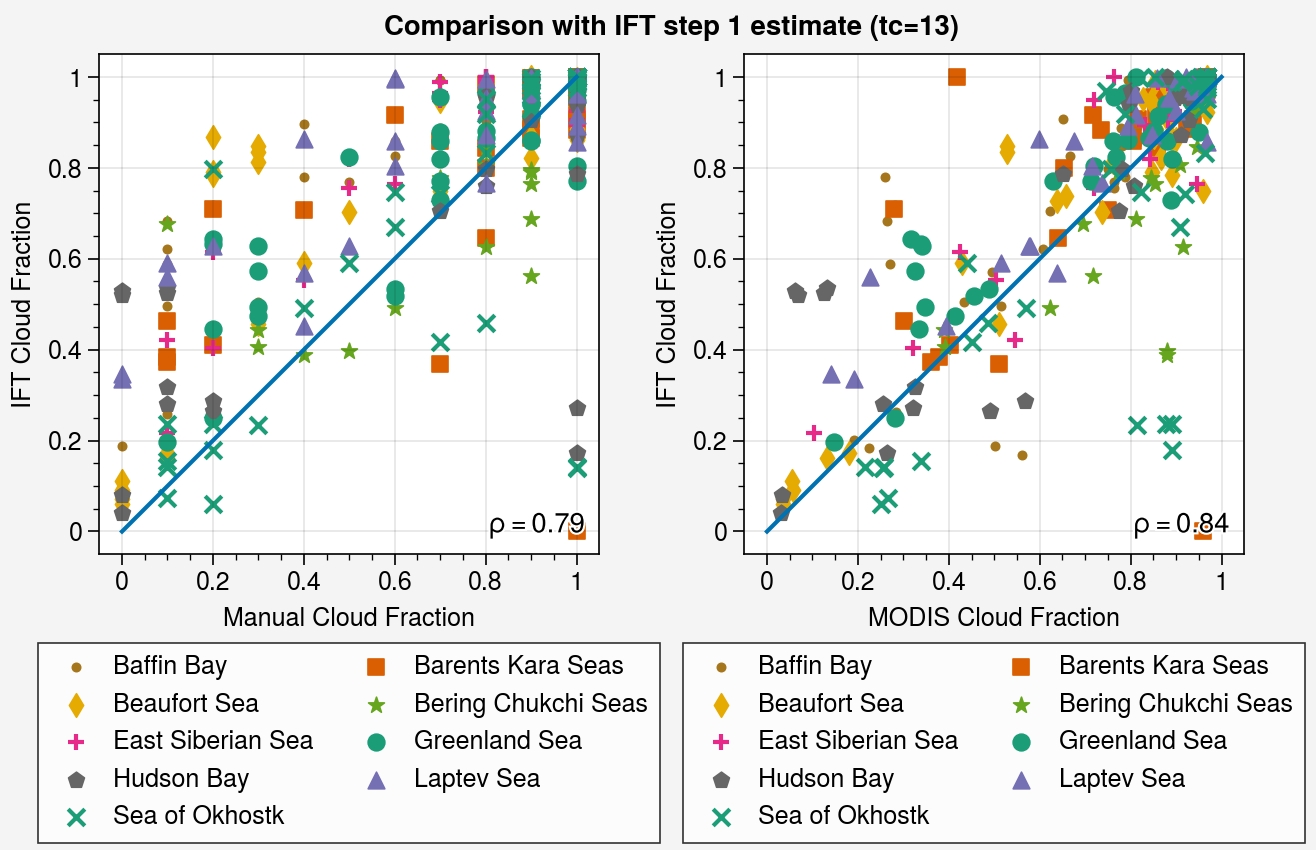

In [21]:
regions = pd.read_csv(dataloc + '/data/metadata/region_definitions.csv', index_col=0)

colors = {region: c['color'] for region, c in zip(
            regions.index,
            pplt.Cycle('dark2', len(regions)))}
markerstyles = {region: ls for region, ls in zip(regions.index,
                        ['o', 's', '^', '+', '*', 'd', '.', 'p', 'x'])}

regions['print_title'] = [c.replace('_', ' ').title().replace('Of', 'of') for c in regions.index]
regions = regions.sort_values('center_lon')
# Estimate from 
tc = 13
for case in fc_images:
    df.loc[case, 'ift_tc13_est'] = np.mean(fc_images[case][0,:,:] > tc)
    
fig, axs = pplt.subplots(ncols=2, share=False)
for ax, col in zip(axs, ['cloud_fraction_manual', 'cloud_fraction_modis']):
    for region, group in df.groupby('region'):
    
        ax.scatter(group[col], group['ift_tc13_est'], label=regions.loc[region, 'print_title'],
               m=markerstyles[region], color=colors[region])
    ax.legend(loc='b', ncols=2)
    ax.plot([0, 1], [0, 1])
    ax.format(ylim=(-0.05, 1.05), xlim=(-0.05, 1.05),
          ylabel='IFT Cloud Fraction')
    ax.format(lrtitle='$\\rho=$' + str(np.round(df[col].corr(df['ift_tc13_est']), 2)))
axs[0].format(xlabel='Manual Cloud Fraction')
axs[1].format(xlabel='MODIS Cloud Fraction')

axs.format(suptitle='Comparison with IFT step 1 estimate (tc=13)')
# fig.save('../figures/manual_modis_cloud_comparison.png', dpi=300)

In [160]:
# Outliers
df.loc[np.abs((df.cloud_fraction_modis - df.ift_tc13_est)) > 0.5, ['region', 'cloud_fraction_modis', 'cloud_fraction_manual']]

region  cloud_fraction_modis  cloud_fraction_manual
002_terra         baffin_bay              0.259287                    0.2
039_aqua   barents_kara_seas              0.958797                    1.0
042_terra  barents_kara_seas              0.417928                    1.0
179_aqua      sea_of_okhostk              0.815057                    0.3
179_terra     sea_of_okhostk              0.891299                    0.2
181_aqua      sea_of_okhostk              0.878736                    0.1
181_terra     sea_of_okhostk              0.891621                    0.2

# Pixel unmasking: identifying optically thin clouds
The original algorithm is
1. Mask all pixels with $l_1 > 110 = T_C$.
2. Unmask pixels with $l_1 < 200 = T_1$ and $l_2 > 190 = T_2$.
3. Unmask pixels with $l_1/l_2 < 0.75 = R_{1,2}$.

In the prior sections, we have found that the first step underestimates the total cloud cover (noting, however, that this high threshold was set just to mask the clouds with the highest opacity). To identify the thin clouds, we have three parameters to adjust, making the optimization a bit more challenging. 



Parameters to optimize over
1. $T_1$. Operates on channel 1.
2. $T_2$. Operates on channel 2.
3. $R_{1,2}$. Ratio of $T_1$ and $T_2$. Pixels with $R_{1,2}$ less than the threshold are unmasked.

This all connects via drawing a piecewise linear parametrized curve dividing cloud from non-cloud pixels.

In [160]:
import skimage
case = '152_aqua'

T1 = 160
T2 = 200
R_lower = 0
R_upper = 0.6
tc = 27

clouds_view = fc_images[case][0,:,:] > tc # true == cloudy pixel
mask_b7b2 = (fc_images[case][0,:,:] < T1) & (fc_images[case][1,:,:] > T2) # true == thin cloud
mask_ratio = fc_images[case][0,:,:]/fc_images[case][1,:,:]
mask_cloud_ice = (mask_ratio > R_lower) & (mask_ratio < R_upper)
mask_cloud_ice = mask_cloud_ice & mask_b7b2
cloud_mask = ~(mask_cloud_ice | ~clouds_view)

/var/folders/_1/dv6d0pjn20bgy9ysl0pfsbr40000gn/T/ipykernel_89780/1343653989.py:12: RuntimeWarning: divide by zero encountered in divide
  mask_ratio = fc_images[case][0,:,:]/fc_images[case][1,:,:]
/var/folders/_1/dv6d0pjn20bgy9ysl0pfsbr40000gn/T/ipykernel_89780/1343653989.py:12: RuntimeWarning: invalid value encountered in divide
  mask_ratio = fc_images[case][0,:,:]/fc_images[case][1,:,:]


In [161]:
def generate_masks(fc_image, t1, t2, r_lower, r_upper, tc):
    """Generate the all-cloud and opaque-cloud masks. Opaque cloud mask is defined as a subset
    of the all-cloud mask where the ice floes are visible."""
    clouds_view = fc_image[0,:,:] > tc # true == cloudy pixel
    mask_b7b2 = (fc_image[0,:,:] < t1) & (fc_image[1,:,:] > t2) # true == thin cloud
    mask_ratio = fc_image[0,:,:]/fc_image[1,:,:]
    mask_cloud_ice = (mask_ratio > r_lower) & (mask_ratio < r_upper)
    mask_cloud_ice = mask_cloud_ice & mask_b7b2
    cloud_mask = ~(mask_cloud_ice | ~clouds_view)
    return clouds_view, cloud_mask

In [162]:
def cloud_fraction_loss_function(new_mask, old_mask):
    """Relative change in cloud fraction against the old mask.
    If no clouds, then return 0. New mask should be 1 where there are clouds."""

    cf_new = np.mean(new_mask)
    cf_old = np.mean(old_mask)
    if cf_old > 1e-4:
        return (cf_old - cf_new)/cf_old
    else:
        return 0

def sea_ice_fraction_loss_function(new_mask, sea_ice_labels):
    """Relative decrease in sea ice cover from ground truth (sea_ice_labels) to the new_mask.
    If no sea ice, return 0"""

    sea_ice = np.sum(sea_ice_labels > 0)
    if sea_ice == 0:
        return 0

    uncovered_ice = np.sum((sea_ice_labels > 0) & ~new_mask)
    return (sea_ice - uncovered_ice)/sea_ice


/var/folders/_1/dv6d0pjn20bgy9ysl0pfsbr40000gn/T/ipykernel_89780/4070359669.py:13: RuntimeWarning: divide by zero encountered in divide
  mask_ratio = b7/b2
/var/folders/_1/dv6d0pjn20bgy9ysl0pfsbr40000gn/T/ipykernel_89780/4070359669.py:13: RuntimeWarning: invalid value encountered in divide
  mask_ratio = b7/b2
/var/folders/_1/dv6d0pjn20bgy9ysl0pfsbr40000gn/T/ipykernel_89780/1523296688.py:6: RuntimeWarning: divide by zero encountered in divide
  mask_ratio = fc_image[0,:,:]/fc_image[1,:,:]
/var/folders/_1/dv6d0pjn20bgy9ysl0pfsbr40000gn/T/ipykernel_89780/1523296688.py:6: RuntimeWarning: invalid value encountered in divide
  mask_ratio = fc_image[0,:,:]/fc_image[1,:,:]
/opt/miniconda3/envs/cal-val/lib/python3.9/site-packages/numpy/ma/core.py:467: RuntimeWarning: invalid value encountered in cast
  fill_value = np.array(fill_value, copy=False, dtype=ndtype)


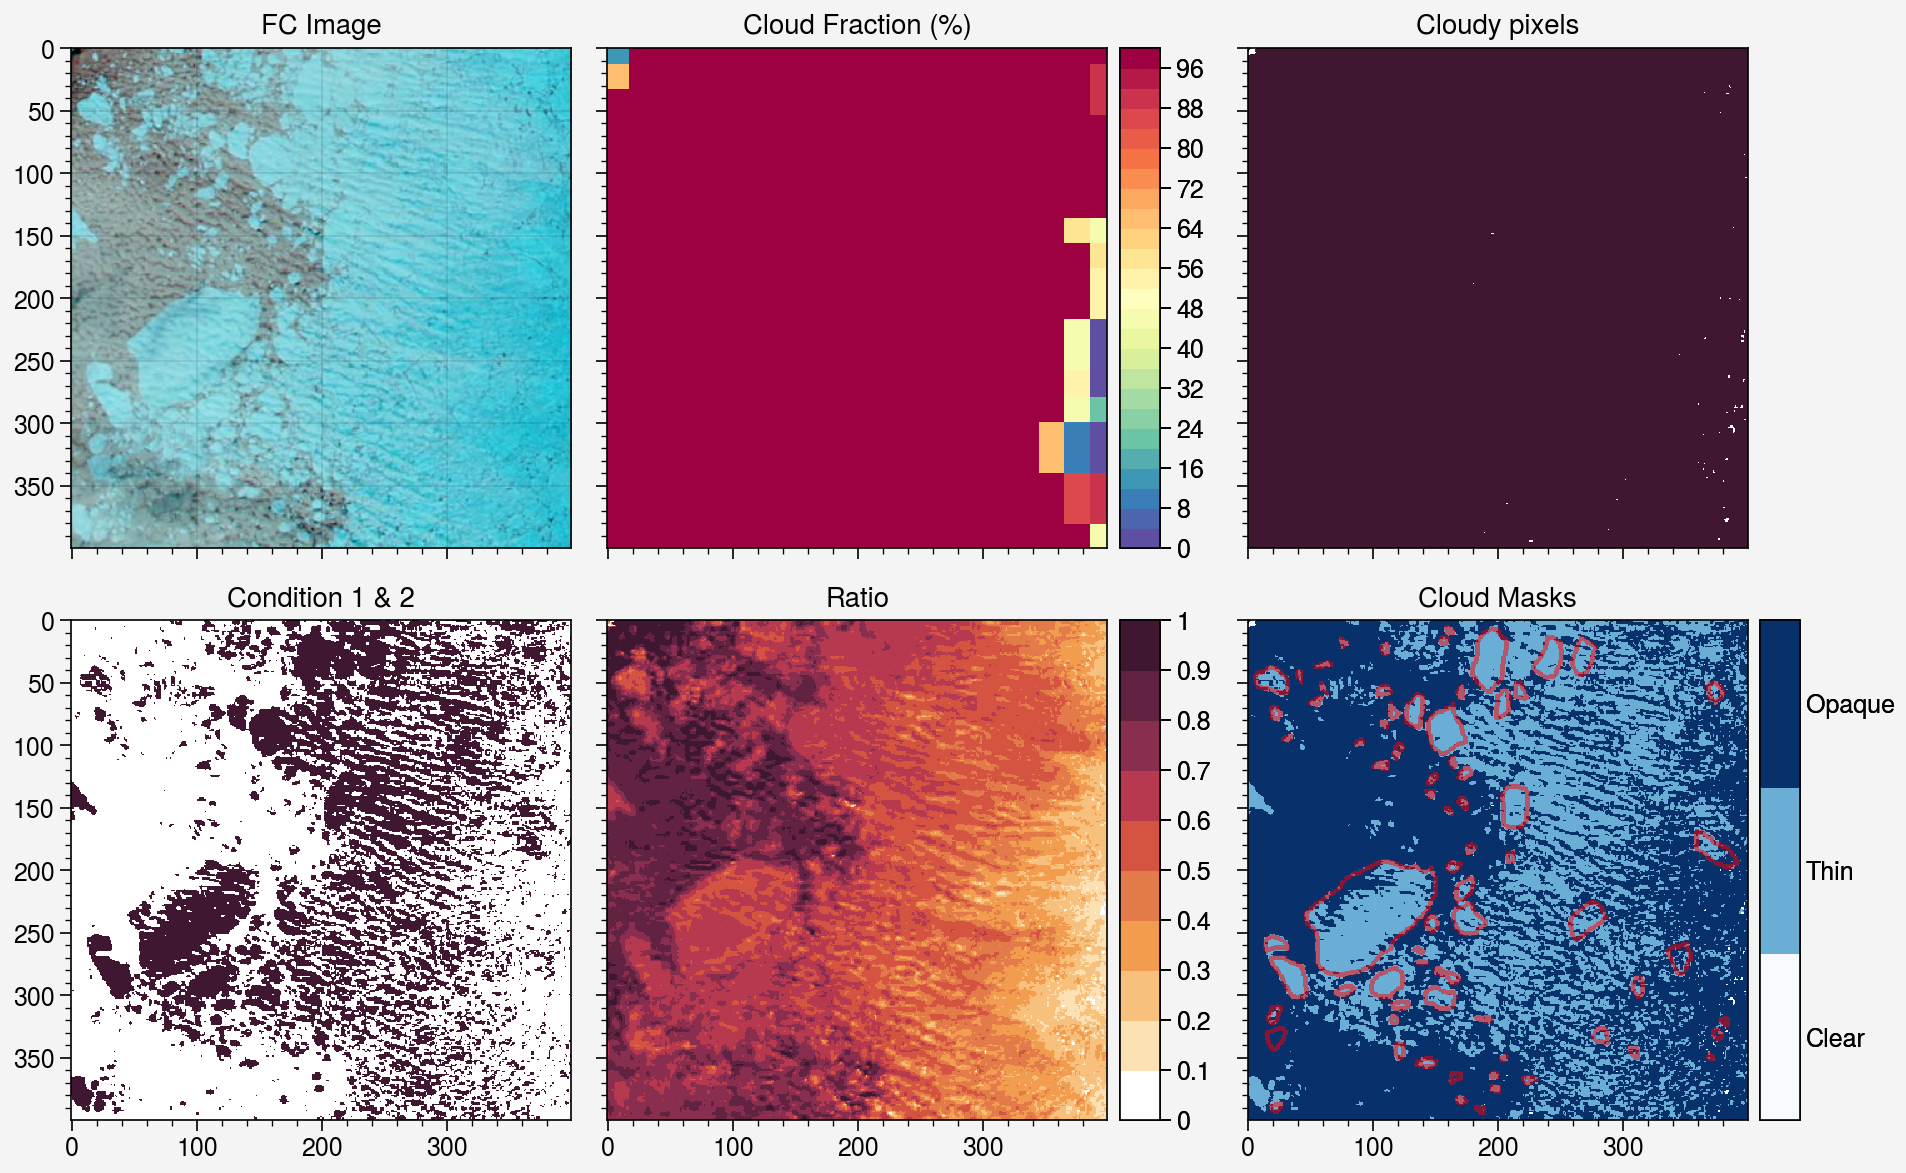

In [163]:
case = '019_aqua'
T1 = 190
T2 = 200
R_lower = 0
R_upper = 0.75
tc = 14

# clouds_view = fc_images[case][0,:,:] > tc # true == cloudy pixel
b7 = fc_images[case][0,:,:]
b2 = fc_images[case][1,:,:]

mask_b7b2 = (b7 < T1) & (b2 > T2) # true == thin cloud
mask_ratio = b7/b2
mask_cloud_ice = (mask_ratio > R_lower) & (mask_ratio < R_upper)
mask_cloud_ice = mask_cloud_ice & mask_b7b2
clouds_view, cloud_mask = generate_masks(fc_images[case], t1=T1, t2=T2, r_lower=0, r_upper=R_upper, tc=tc)

fig, axs = pplt.subplots(ncols=3, nrows=2)
layered_mask = ((cloud_mask).astype(float) + clouds_view.astype(float))/2
for ax, data, title in zip(axs, [fc_images[case], cf_images[case], clouds_view, mask_b7b2, mask_ratio, layered_mask],
                          ['FC Image', 'Cloud Fraction (%)', 'Cloudy pixels', 'Condition 1 & 2', 'Ratio', 'Cloud Masks']):
    if title == 'FC Image':
        ax.imshow(reshape_as_image(data))
    elif title == 'Cloud Fraction (%)':
        ax.pcolormesh(data.values, vmin=0, vmax=100, N=32, cmap='spectral_r', colorbar='r')
    else:
        c = ax.pcolormesh(data, vmin=0, vmax=1)
        if title=='Ratio':
            ax.colorbar(c, loc='r')
        if title=='Cloud Masks':
            c = ax.pcolormesh(data, N=3, cmap='blues')
            ax.colorbar(c, ticks=[.2, 0.6, 1], ticklabels=['Clear', 'Thin', 'Opaque'], ticklen=0.1)

    ax.format(title=title, yreverse=True)
manual_floe_labels = lb_images[case][0,:,:] % 2

outlines = manual_floe_labels - skimage.morphology.erosion(manual_floe_labels, skimage.morphology.disk(4))
axs[1, 2].pcolormesh(np.ma.masked_array(outlines, outlines==0), color='r', alpha=0.5)


axs.format(yreverse=True)
# axs[1,1].format(yreverse=True)

The calibration in this section aims to minimize the reduction in the cloud mask while maximizing the fraction of manually-labeled ice floes that are uncovered. A big challenge here is that the images vary quite a bit in the number of ice floes. It is not obvious how we should weight the results, whether by pixels or what.

/var/folders/dc/61xkz8s134xgs5c2fmqrjgrr0000gn/T/ipykernel_21557/1393491453.py:16: RuntimeWarning: divide by zero encountered in divide
  nsdii2 = (b4 - b2)/(b4 + b2)
/var/folders/dc/61xkz8s134xgs5c2fmqrjgrr0000gn/T/ipykernel_21557/1393491453.py:16: RuntimeWarning: invalid value encountered in divide
  nsdii2 = (b4 - b2)/(b4 + b2)
/var/folders/dc/61xkz8s134xgs5c2fmqrjgrr0000gn/T/ipykernel_21557/1393491453.py:19: RuntimeWarning: divide by zero encountered in divide
  mask_ratio = b7/b2
/var/folders/dc/61xkz8s134xgs5c2fmqrjgrr0000gn/T/ipykernel_21557/1393491453.py:19: RuntimeWarning: invalid value encountered in divide
  mask_ratio = b7/b2
/var/folders/dc/61xkz8s134xgs5c2fmqrjgrr0000gn/T/ipykernel_21557/1523296688.py:6: RuntimeWarning: divide by zero encountered in divide
  mask_ratio = fc_image[0,:,:]/fc_image[1,:,:]
/var/folders/dc/61xkz8s134xgs5c2fmqrjgrr0000gn/T/ipykernel_21557/1523296688.py:6: RuntimeWarning: invalid value encountered in divide
  mask_ratio = fc_image[0,:,:]/fc_imag

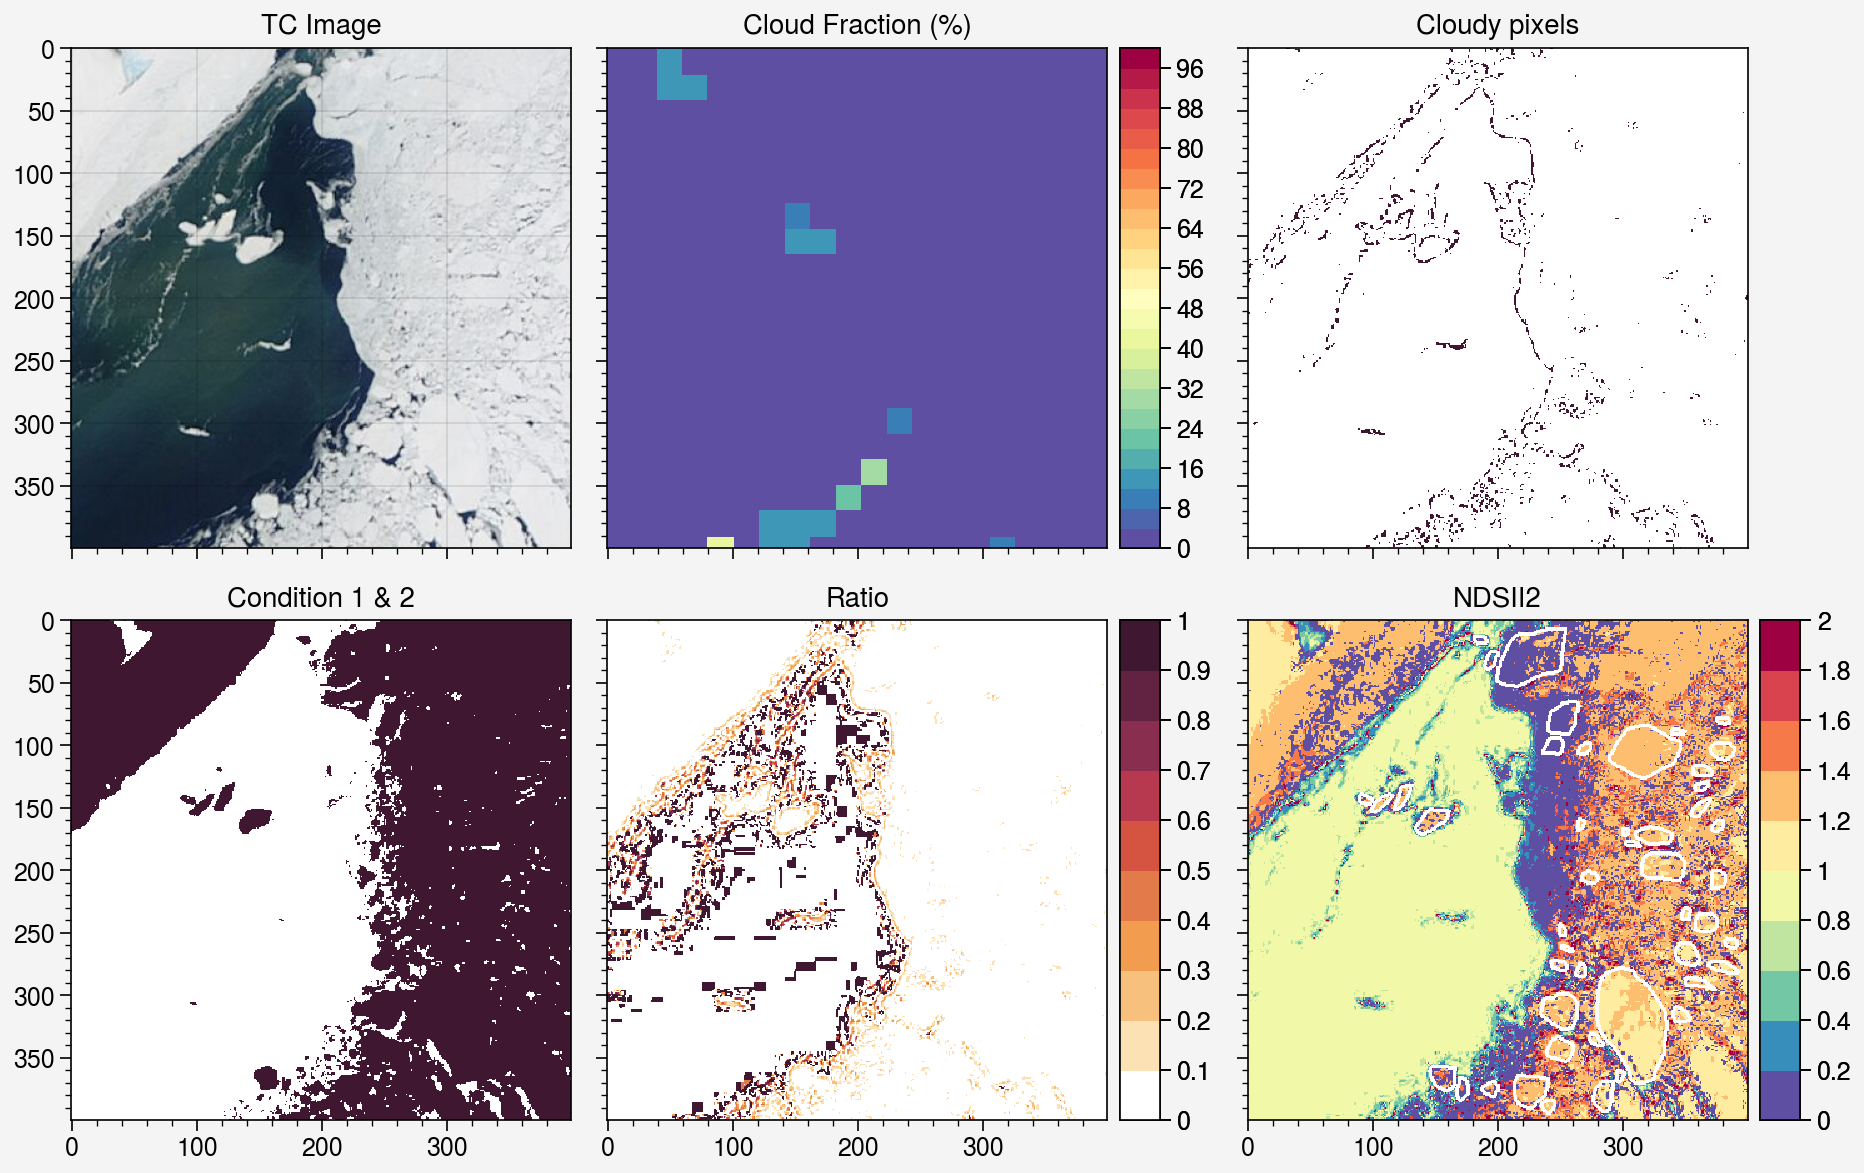

In [338]:
case = '081_aqua'
case = '019_aqua'
case = '048_terra'
T1 = 190
T2 = 200
R_lower = 0
R_upper = 0.75
tc = 26

# clouds_view = fc_images[case][0,:,:] > tc # true == cloudy pixel
b4 = tc_images[case][1,:,:]

b7 = fc_images[case][0,:,:]
b2 = fc_images[case][1,:,:]

nsdii2 = (b4 - b2)/(b4 + b2)

mask_b7b2 = (b7 < T1) & (b2 > T2) # true == thin cloud
mask_ratio = b7/b2
mask_cloud_ice = (mask_ratio > R_lower) & (mask_ratio < R_upper)
mask_cloud_ice = mask_cloud_ice & mask_b7b2
clouds_view, cloud_mask = generate_masks(fc_images[case], t1=T1, t2=T2, r_lower=0, r_upper=R_upper, tc=tc)

fig, axs = pplt.subplots(ncols=3, nrows=2)
layered_mask = ((cloud_mask).astype(float) + clouds_view.astype(float))/2
for ax, data, title in zip(axs, [tc_images[case], cf_images[case], clouds_view, mask_b7b2, mask_ratio, nsdii2],
                          ['TC Image', 'Cloud Fraction (%)', 'Cloudy pixels', 'Condition 1 & 2', 'Ratio', 'NDSII2']):
    if title == 'TC Image':
        ax.imshow(reshape_as_image(data))
    elif title == 'Cloud Fraction (%)':
        ax.pcolormesh(data.values, vmin=0, vmax=100, N=32, cmap='spectral_r', colorbar='r')
    else:
        c = ax.pcolormesh(data, N=10, vmin=0, vmax=1)
        if title=='Ratio':
            ax.colorbar(c, loc='r')
        if title=='NDSII2':
            c = ax.pcolormesh(data, N=10, vmin=0, vmax=2, cmap='spectral_r')
            ax.colorbar(c)

    ax.format(title=title, yreverse=True)
manual_floe_labels = lb_images[case][0,:,:] % 2

outlines = manual_floe_labels - skimage.morphology.erosion(manual_floe_labels, skimage.morphology.disk(2))
axs[1, 2].pcolormesh(np.ma.masked_array(outlines, outlines==0), color='w', alpha=1)


axs.format(yreverse=True)
# axs[1,1].format(yreverse=True)

# Selecting reference regions for pixel thresholds
1. Using MASIE ice and land to find open water

In [280]:
LM_modis.shape


(400, 400, 4)

In [335]:
for case in lb_images:
    TC = reshape_as_image(tc_images[case])
    FC = reshape_as_image(fc_images[case])
    LM_modis = np.sum(lm_images[case], axis=0) > 0
    LM_masie = reshape_as_image(ml_images[case])
    SI_masie = reshape_as_image(mi_images[case])
    
    floes_manual = lb_images[case][0,:,:] > 0
    lfast_manual = lf_images[case][0,:,:] > 0
    
    fig, ax = pplt.subplots(ncols=3)
    ax[0].imshow(TC)
    ax[1].imshow(FC)
    ax[2].imshow(np.ma.masked_array(LM_modis, mask=~LM_modis), c='k')
    ax[2].imshow(np.ma.masked_array(SI_masie, mask=SI_masie <= 1), c='b', alpha=0.5)
    ax[2].imshow(np.ma.masked_array(floes_manual, mask=floes_manual == 0), c='r', alpha=0.5)
    ax[2].imshow(np.ma.masked_array(lfast_manual, mask=lfast_manual == 0), c='gold', alpha=0.5)
    h = []
    for color in ['k', 'b', 'r', 'gold']:
        h.append(ax[2].plot([],[],lw=0, m='s',  c=color, alpha=0.5))
    ax[2].legend(h, ['landmask', 'masie ice', 'manual floes', 'manual landfast'], loc='r', ncols=1)
    
    ax.format(suptitle=case)
    ax[0].format(title='Truecolor')
    ax[1].format(title='Falsecolor')
    ax[2].format(title='Classification')
    fig.save('../figures/test_labels/' + case + '_tc_fc_labels.png', dpi=300)
    pplt.close(fig)

TBD: 
* Assign test / train cases
* Check images with full cloud cover - any where the manual estimate especially disagrees? What threshold to use on cloud fraction for mask comparison?
* Identify cases where the cloud mask gets confused by the ice edge
* How to aggegrate? Do I fit a distribution?
* How should I report the cases where the mask should not have been removed?
* Should the B7/B2 ratio actually have a shift (e.g. (B7 + x)/(B2 + y) < ratio? Where should the line be drawn?
* All of this is really just using a piecewise linear threshold function.

# New approach: binning data by cloud/ice presence for plotting against 2D schematics

TBD: use metadata column to identify where there is need for ignoring the MODIS cloud fraction



In [22]:
training_idx = df.sample(frac=2/3, random_state=97234).sort_index().index
test_idx = pd.Index([x for x in df.index if x not in training_idx])

In [274]:
b7_ice_nocloud = []
b2_ice_nocloud = []
case_ice_nocloud = []

b7_ice_cloud = []
b2_ice_cloud = []
case_ice_cloud = []

b7_cloud = []
b2_cloud = []
case_cloud = []

count = 0
min_cloud_frac = 10
for row, data in df.iterrows():
    case = '{cn}_{s}'.format(cn=data.case_number, s=data.satellite)
    b7 = fc_images[case][0,:,:]
    b2 = fc_images[case][1,:,:]
    # get boolean masks for each of these
    modis_cloud = cf_images[case] > min_cloud_frac
    land = np.sum(lm_images[case], axis=0) > 1 # replace with boolean mask in the end
    
    if case in lb_images:
        if data.floe_obscuration in ['none', 'light']:
            ice_floes = lb_images[case][0,:,:] > 0
            fast_ice = lf_images[case][0,:,:] > 0
            ice_nocloud_pixels = (ice_floes | fast_ice) & ~modis_cloud
            ice_cloud_pixels = (ice_floes | fast_ice) & modis_cloud                
            
            b7_ice_nocloud.append(b7[ice_nocloud_pixels])
            b2_ice_nocloud.append(b2[ice_nocloud_pixels])
            case_ice_nocloud.append([case] * ice_nocloud_pixels.astype(int).sum().sum())
            
            b7_ice_cloud.append(b7[ice_cloud_pixels])
            b2_ice_cloud.append(b2[ice_cloud_pixels])
            case_ice_cloud.append([case] * ice_cloud_pixels.astype(int).sum().sum())
            
    if data.visible_sea_ice == 'no':
        if data.visible_landfast_ice == 'no':
            if data.cloud_category_manual == 'opaque':
                cloud_pixels = modis_cloud & ~land
                b7_cloud.append(b7[cloud_pixels])
                b2_cloud.append(b2[cloud_pixels])
                
                case_cloud.append([case] * cloud_pixels.astype(int).sum().sum())
    else:
        if data.cloud_category_manual == 'opaque':
            if case in lb_images:
                no_ice = ~(ice_floes | fast_ice)
                cloud_pixels = no_ice & modis_cloud & ~land
                b7_cloud.append(b7[cloud_pixels])
                b2_cloud.append(b2[cloud_pixels])
                case_cloud.append([case] * cloud_pixels.astype(int).sum().sum())
                
b7_ice_nocloud = np.hstack(b7_ice_nocloud)
b2_ice_nocloud = np.hstack(b2_ice_nocloud)
case_ice_nocloud = np.hstack(case_ice_nocloud)

b7_ice_cloud = np.hstack(b7_ice_cloud)
b2_ice_cloud = np.hstack(b2_ice_cloud)
case_ice_cloud = np.hstack(case_ice_cloud)

b7_cloud = np.hstack(b7_cloud)
b2_cloud = np.hstack(b2_cloud)    
case_cloud = np.hstack(case_cloud)

In [277]:
test.shape

(659490, 3)

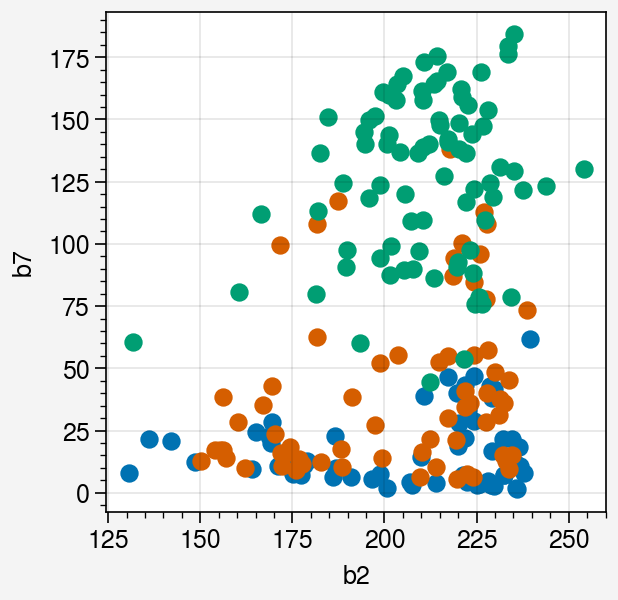

In [301]:
mean_data = []
fig, ax = pplt.subplots()
test = pd.DataFrame({'case': case_ice_nocloud, 'b7': b7_ice_nocloud, 'b2': b2_ice_nocloud})
test = test.groupby('case').filter(lambda x: len(x) > 10)
test_mean = test.groupby('case').mean()
test_mean['category'] = 'ice'
mean_data.append(test_mean.reset_index())

ax.scatter(test_mean['b2'], test_mean['b7'])

test = pd.DataFrame({'case': case_ice_cloud, 'b7': b7_ice_cloud, 'b2': b2_ice_cloud})
test_mean = test.groupby('case').mean()
test = test.groupby('case').filter(lambda x: len(x) > 10)
test_mean['category'] = 'ice_cloud'
mean_data.append(test_mean.reset_index())

ax.scatter(test_mean['b2'], test_mean['b7'])

test = pd.DataFrame({'case': case_cloud, 'b7': b7_cloud, 'b2': b2_cloud})
test_mean = test.groupby('case').mean()
test = test.groupby('case').filter(lambda x: len(x) > 10)
test_mean['category'] = 'cloud'
mean_data.append(test_mean.reset_index())

ax.scatter(test_mean['b2'], test_mean['b7'])
mean_data = pd.concat(mean_data)

F1 score = TP / (TP + 1/2(FP + FN))

In [302]:
def cloud_mask(b2, b7, t0, t_b7, t_b2, t_b7b2):
    step_1 = b7 > t0
    step_2 = b7 < b2*t_b7b2
    step_3 = (b7 < t_b7) & (b2 > t_b2)
    return step_1 & ~(step_2 | step_3)
mean_data['cloud'] = cloud_mask(mean_data['b2'], mean_data['b7'], 110, 200, 190, 0.75)

13 200 55.12529231181547 0.16


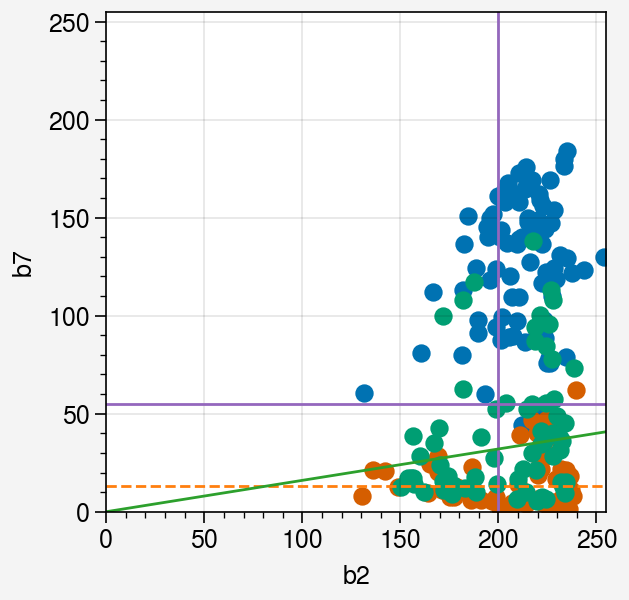

In [312]:
fig, ax = pplt.subplots()

idx = mean_data['category'] == 'ice'
tau_init=13
tau_b2 = 200
tau_b7, tau_b7b2 = get_thresholds(150, mean_data.loc[idx, 'b2'], mean_data.loc[idx, 'b7'])
print(tau_init, tau_b2, tau_b7, tau_b7b2)

ax.axhline(tau_b7, ls='-', label='B7 < tau_7', lw=1, color='tab:purple')
ax.axvline(tau_b2, ls='-', label='B2 < tau_2', lw=1, color='tab:purple')
ax.axhline(tau_init, ls='--', label='B7 > tau_0', lw=1, color='tab:orange')
ax.plot([0, 255], [0, tau_b7b2*255], color='tab:green', lw=1)


mean_data['cloud'] = cloud_mask(mean_data['b2'], mean_data['b7'], tau_init, tau_b7, tau_b2, tau_b7b2)
for name, group in mean_data.groupby('category'):
    ax.scatter(group['b2'], group['b7'])
ax.format(ylim=(0, 255), xlim=(0, 255))

(176.51314398550727, 0.45)

In [230]:
print('Number of pixels (thousands)')
for title, data in zip(['B7 Clearsky Ice', 'B2 Clearsky Ice', 'B7 Cloudy Ice', 'B2 Cloudy Ice', 'B7 Cloud', 'B2 Cloud'],
                       [b7_ice_nocloud, b2_ice_nocloud, b7_ice_cloud, b2_ice_cloud, b7_cloud, b2_cloud]):
    print(title, int(np.round(len(data)/1e3, 0)))
    

Number of pixels (thousands)
B7 Clearsky Ice 765
B2 Clearsky Ice 765
B7 Cloudy Ice 1253
B2 Cloudy Ice 1253
B7 Cloud 12108
B2 Cloud 12108


In [231]:
def get_thresholds(b2_threshold, b2_data, b7_data, method='quantile'):
    """Starting from a proposed b2 threshold, estimate thresholds for b7
    and for the b7/b2 ratio based on the distribution of b2_data and b7_data."""


    
    
    b7_idx = (b2_data > b2_threshold) & (b7_data > 5)
    r_idx = ((b2_data > 0) & (b2_data <= b2_threshold)) & (b7_data > 5)
    if method == 'quantile':    
        r = b7_data[r_idx] / b2_data[r_idx]
        b7b2_threshold = np.round(np.quantile(r, 0.99), 2)
        b7_threshold = np.quantile(b7_data[b7_idx], 0.99)
        if b7_threshold < b2_threshold * b7b2_threshold:
            b7_threshold = b2_threshold * b7b2_threshold
        
        return (b7_threshold, b7b2_threshold)
        
    elif method == 'iqr_outlier':
        b7_median = np.median(b7_data[b7_idx])
        b7_iqr = np.diff(np.quantile(b7_data[b7_idx], [0.25, 0.75])).squeeze()
        b7_threshold = b7_median + 1.5*b7_iqr

        # b7_subset = b7_data[b2_data <= b2_threshold]
        # b2_subset = b2_data[b2_data <= b2_threshold]
        r = b7_data[r_idx] / b2_data[r_idx]
        # r = r[(r > 0) & (r < 1e3)]
        r_median = np.median(r)
        r_iqr = np.diff(np.quantile(r, [0.25, 0.75])).squeeze()
        b7b2_threshold = np.round(r_median + 1.5*r_iqr, 2)
        return b7_threshold, b7b2_threshold
        

tau_init = 13
def compute_error(tau_init, tau_b2, tau_b7, tau_b7b2, b2_data, b7_data):
    """Computes the fraction of cloud-covered ice pixels labeled as clear"""
    idx = b7_data >= tau_init
    idx = idx & ~((tau_b2 < b2_data) & (tau_b7 > b7_data))
    idx = idx & (b7_data / b2_data > tau_b7b2)
    return(1-np.sum(idx)/len(idx))

13 170 81.6 0.48


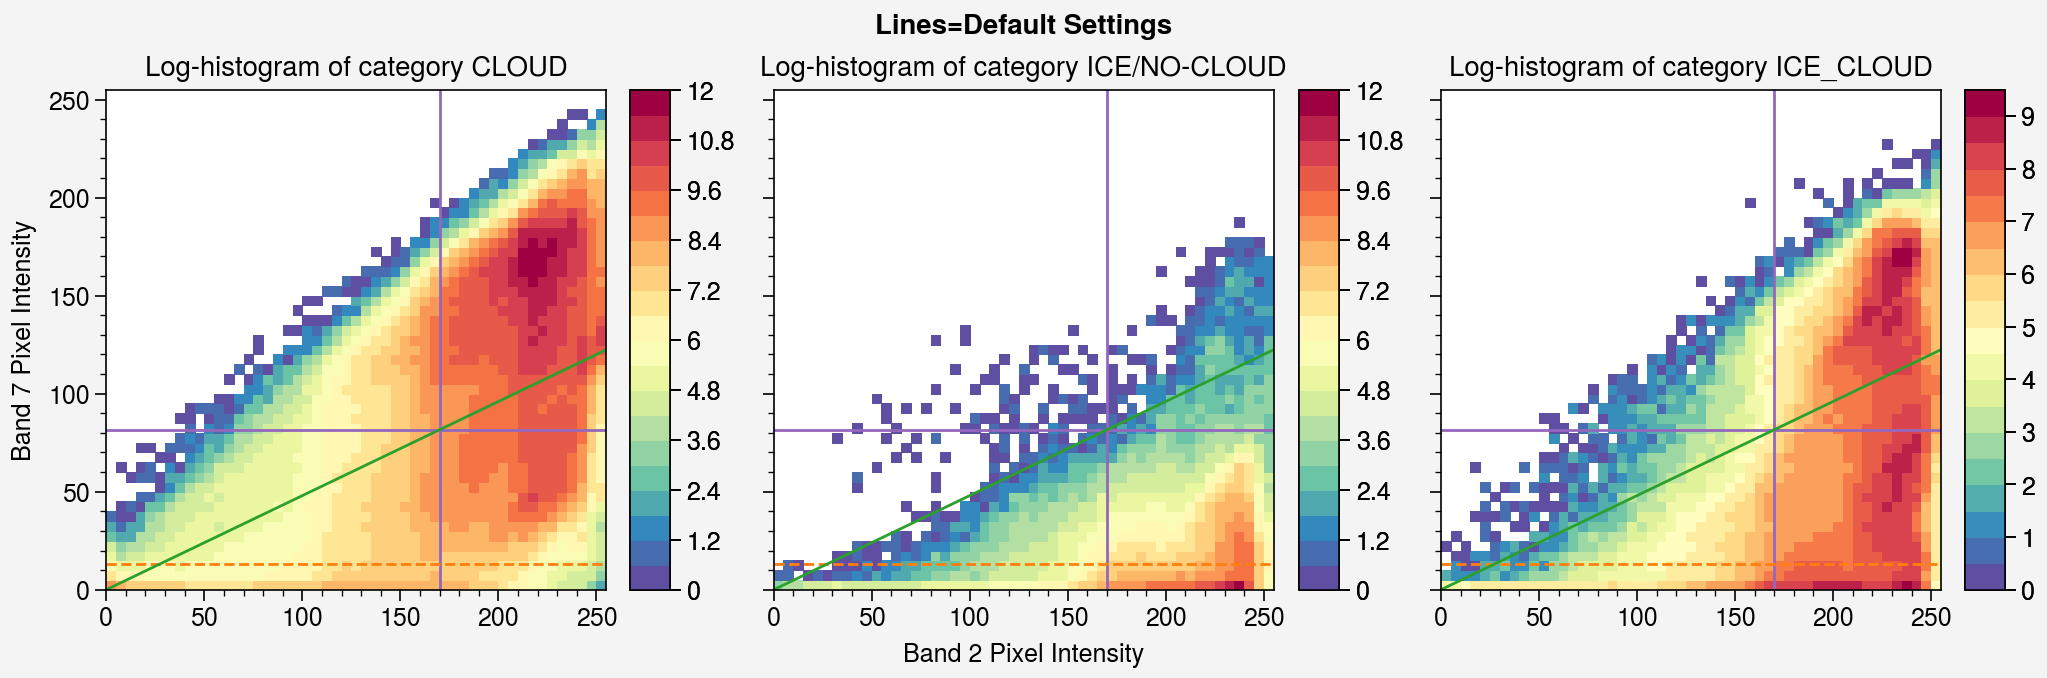

In [232]:
tau_0 = 110
tau_7 = 200
tau_2 = 190
tau_R = 0.75

fig, axs = pplt.subplots(ncols=3)
ax = axs[0]
bin_centers = np.arange(2.5, 256, 5)
H, _, _ = np.histogram2d(b2_cloud, b7_cloud, bins=[np.arange(0, 256, 5),
                                                     np.arange(0, 256, 5)])
data = pd.DataFrame(H.T, index=bin_centers, columns=bin_centers).where(H.T > 0)

ax.pcolormesh(np.log(data), cmap='spectral_r', N=20, colorbar='r')
ax.format(title='Log-histogram of category CLOUD')

ax = axs[1]
H, _, _ = np.histogram2d(b2_ice_nocloud, b7_ice_nocloud, bins=[np.arange(0, 256, 5),
                                                     np.arange(0, 256, 5)])
data = pd.DataFrame(H.T, index=bin_centers, columns=bin_centers).where(H.T > 0)
ax.pcolormesh(np.log(data), cmap='spectral_r', N=20, colorbar='r')
ax.format(title='Log-histogram of category ICE/NO-CLOUD')

ax = axs[2]
H, _, _ = np.histogram2d(b2_ice_cloud, b7_ice_cloud, bins=[np.arange(0, 256, 5),
                                                     np.arange(0, 256, 5)])
data = pd.DataFrame(H.T, index=bin_centers, columns=bin_centers).where(H.T > 0)

tau_init=13
tau_b2 = 170
tau_b7, tau_b7b2 = get_thresholds(tau_b2, b2_ice_nocloud, b7_ice_nocloud)
print(tau_init, tau_b2, tau_b7, tau_b7b2)
# Unmask and place these in the loop to get the original mask
# ax.axvline(tau_7, ls='-', label='B7 < tau_7', lw=3, color='tab:purple')
# ax.axhline(tau_2, ls='-', label='B2 < tau_2', lw=3, color='tab:purple')
# ax.axhline(tau_0, ls='--', label='B7 > tau_0', lw=3, color='tab:orange')
# ax.plot([0, 255], [0, tau_R*255], color='tab:green', lw=3)
for ax in axs:
    ax.axhline(tau_b7, ls='-', label='B7 < tau_7', lw=1, color='tab:purple')
    ax.axvline(tau_b2, ls='-', label='B2 < tau_2', lw=1, color='tab:purple')
    ax.axhline(tau_init, ls='--', label='B7 > tau_0', lw=1, color='tab:orange')
    ax.plot([0, 255], [0, tau_b7b2*255], color='tab:green', lw=1)


ax.pcolormesh(np.log(data), cmap='spectral_r', N=20, colorbar='r')
ax.format(title='Log-histogram of category ICE_CLOUD')

axs.format(ylabel='Band 7 Pixel Intensity', xlabel='Band 2 Pixel Intensity', suptitle='Lines=Default Settings')
fig.save('../figures/log_histogram_fc_intensities.png', dpi=300)

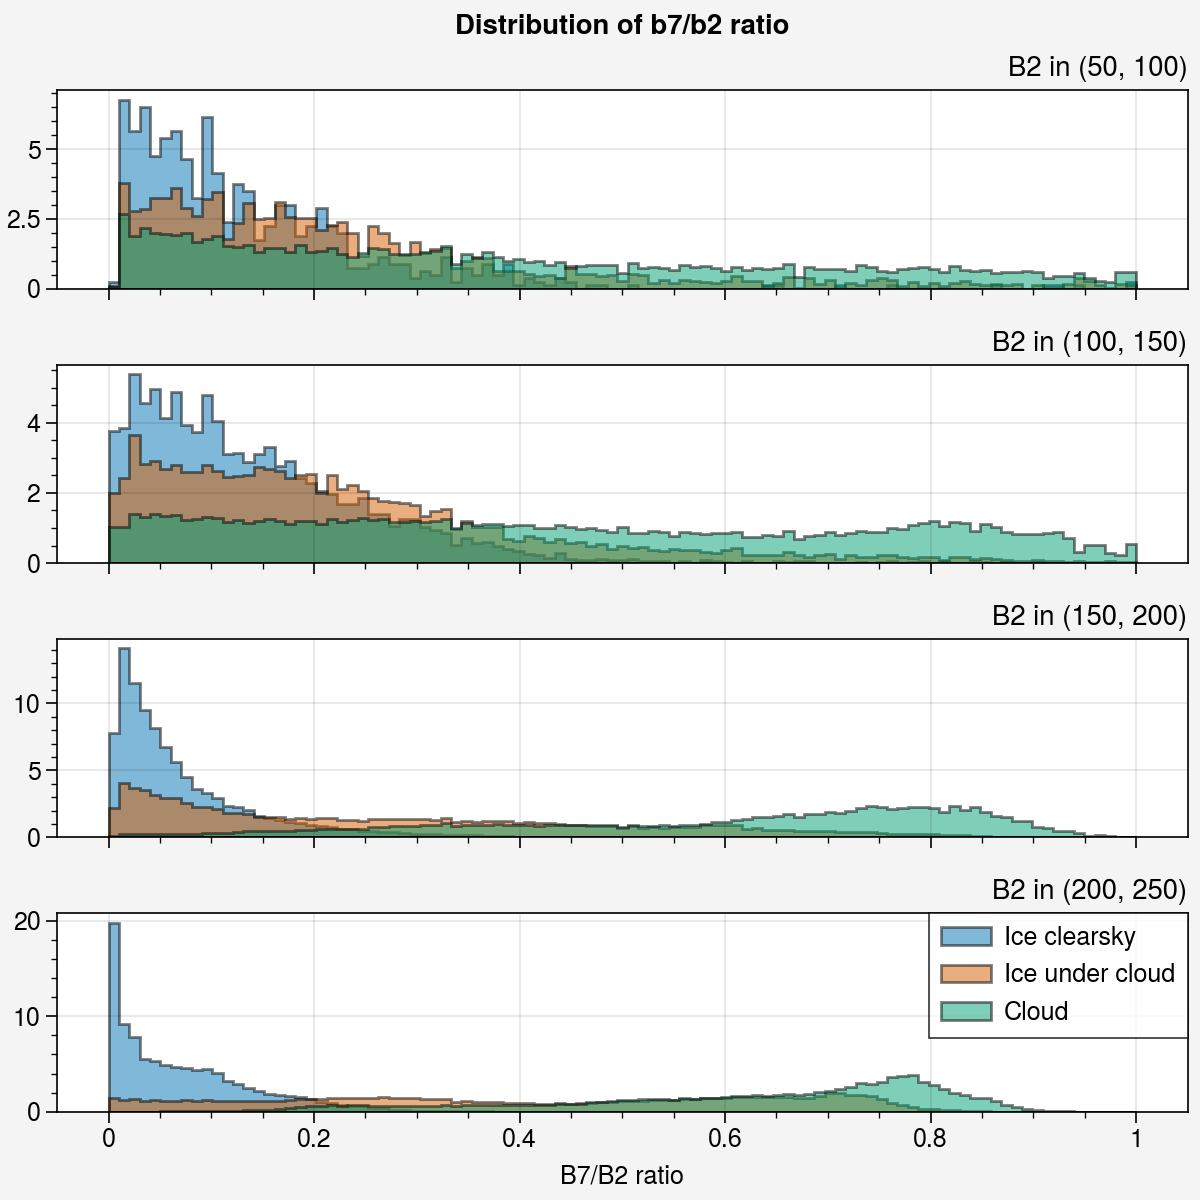

In [233]:
fig, axs = pplt.subplots(width=6, height=6, nrows=4)
b2_data = b2_ice_cloud
b7_data = b7_ice_cloud
for ax, bandstart in zip(axs, np.arange(50, 201, 50)):
    for b2_data, b7_data, label in zip([b2_ice_nocloud, b2_ice_cloud, b2_cloud],
                                       [b7_ice_nocloud, b7_ice_cloud, b7_cloud],
                                       ['Ice clearsky', 'Ice under cloud', 'Cloud']):
        idx = (b2_data > bandstart) & (b2_data <= bandstart + 50)
        idx = idx & (b2_data > 0)
        idx = idx & (b7_data > 0)
        if np.sum(idx) > 1e2:
            _ = ax.hist(b7_data[idx] / b2_data[idx], bins=np.linspace(0, 1, 100), alpha=0.5,
                    density=True, fill=True, ec='k', label=label, lw=1)
    ax.format(rtitle='B2 in ({b0}, {b1})'.format(b0=bandstart, b1=bandstart + 50))
ax.legend(ncols=1)
axs.format(suptitle='Distribution of b7/b2 ratio', xlabel='B7/B2 ratio')

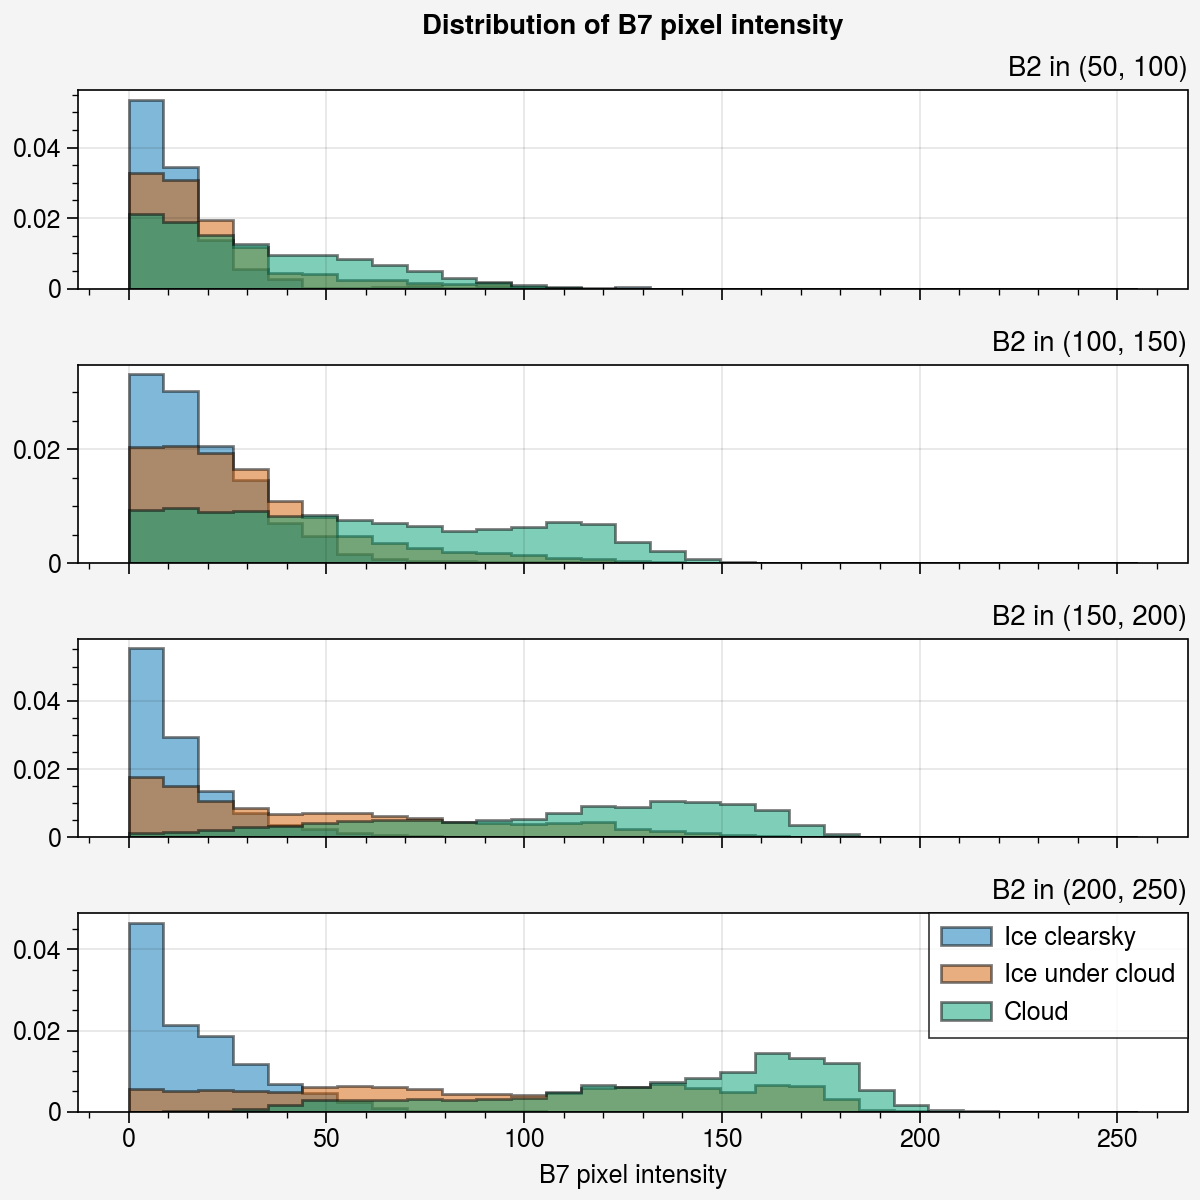

In [234]:
fig, axs = pplt.subplots(width=6, height=6, nrows=4)
b2_data = b2_ice_cloud
b7_data = b7_ice_cloud
for ax, bandstart in zip(axs, np.arange(50, 201, 50)):
    for b2_data, b7_data, label in zip([b2_ice_nocloud, b2_ice_cloud, b2_cloud],
                                       [b7_ice_nocloud, b7_ice_cloud, b7_cloud],
                                       ['Ice clearsky', 'Ice under cloud', 'Cloud']):
        idx = (b2_data > bandstart) & (b2_data <= bandstart + 50)
        idx = idx & (b2_data > 0)
        idx = idx & (b7_data > 0)
        if np.sum(idx) > 1e2:
            _ = ax.hist(b7_data[idx], bins=np.linspace(0, 255, 30), alpha=0.5,
                    density=True, fill=True, ec='k', label=label, lw=1)
    ax.format(rtitle='B2 in ({b0}, {b1})'.format(b0=bandstart, b1=bandstart + 50))
ax.legend(ncols=1)
axs.format(suptitle='Distribution of B7 pixel intensity', xlabel='B7 pixel intensity')

/var/folders/_1/dv6d0pjn20bgy9ysl0pfsbr40000gn/T/ipykernel_89780/927295891.py:24: RuntimeWarning: divide by zero encountered in log
  ax.pcolormesh(binc, binc, np.log(np.ma.masked_array(H, H <= 5)),
/var/folders/_1/dv6d0pjn20bgy9ysl0pfsbr40000gn/T/ipykernel_89780/927295891.py:47: RuntimeWarning: divide by zero encountered in log
  ax.pcolormesh(binc, binc, np.log(np.ma.masked_array(H, H <= 5)),
/var/folders/_1/dv6d0pjn20bgy9ysl0pfsbr40000gn/T/ipykernel_89780/927295891.py:70: RuntimeWarning: divide by zero encountered in log
  ax.pcolormesh(binc, binc, np.log(np.ma.masked_array(H, H <= 5)),


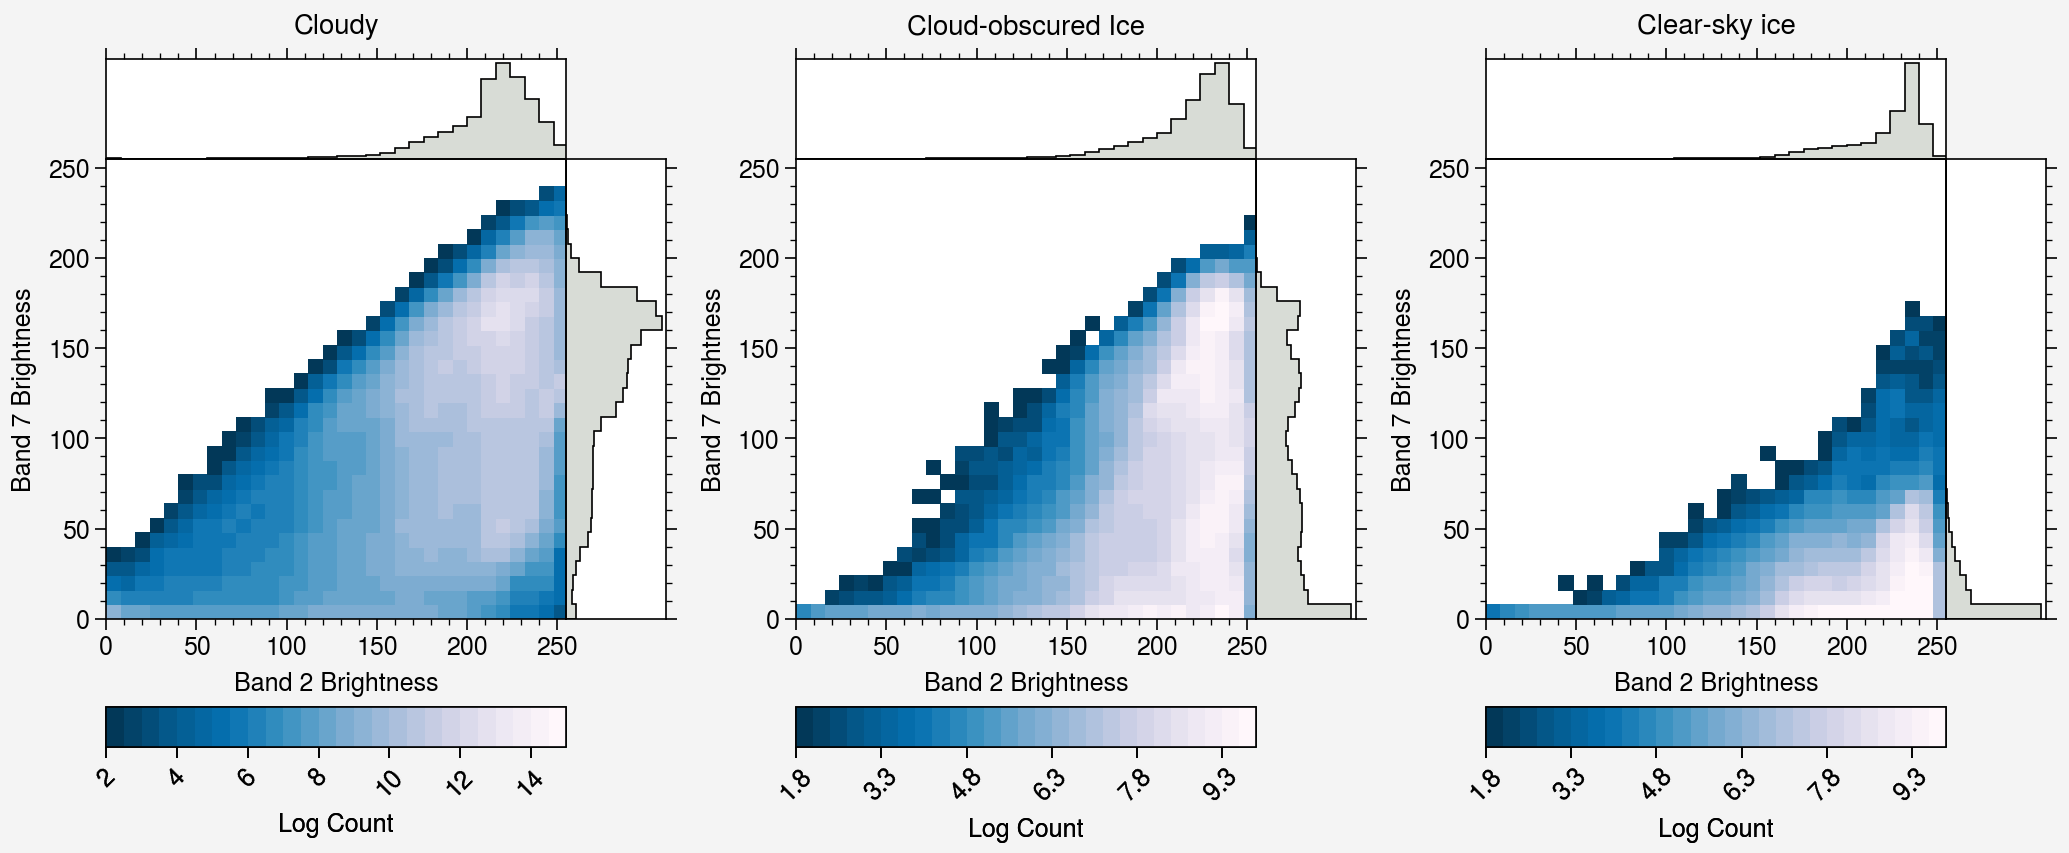

In [235]:
import proplot as pplt
import numpy as np



# Histogram with marginal distributions
fig, axs = pplt.subplots(ncols=3, refwidth=2.3, share=False)

# can loop this with some care
ax = axs[0]

ax.format(titleabove=True,
    title='Cloudy'
)

color = 'light gray'
x = b2_cloud.copy()
y = b7_cloud.copy()

bins = np.linspace(0, 256, 33)
binc = 0.5*(bins[1:] + bins[:-1])
H, _, _ = np.histogram2d(x, y, bins=[bins, bins])
H = H.T
ax.pcolormesh(binc, binc, np.log(np.ma.masked_array(H, H <= 5)),
              vmin=np.log(5), vmax=15, levels=30,
              cmap='PuBu_r', colorbar='b', colorbar_kw={'label': 'Log Count', 'rotation': 45})

# color = pplt.scale_luminance(color, 1.5)  # histogram colors
px = ax.panel('r', space=0)
px.histh(y, bins, color=color, fill=True, ec='k')
px.format(grid=False, xlocator=[], ylabel='Band 7 Brightness', xreverse=False)

px = ax.panel('t', space=0)
px.hist(x, bins, color=color, fill=True, ec='k')
px.format(grid=False, ylocator=[])

ax = axs[1]

x = b2_ice_cloud.copy()
y = b7_ice_cloud.copy()
ax.format(titleabove=True,
    title='Cloud-obscured Ice'
)

H, _, _ = np.histogram2d(x, y, bins=[bins, bins])
H = H.T
ax.pcolormesh(binc, binc, np.log(np.ma.masked_array(H, H <= 5)),
              vmin=np.log(5), vmax=10, levels=30,
              cmap='PuBu_r', colorbar='b', colorbar_kw={'label': 'Log Count', 'rotation': 45})

# color = pplt.scale_luminance(color, 1.5)  # histogram colors
px = ax.panel('r', space=0)
px.histh(y, bins, color=color, fill=True, ec='k')
px.format(grid=False, xlocator=[], ylabel='Band 7 Brightness', xreverse=False)

px = ax.panel('t', space=0)
px.hist(x, bins, color=color, fill=True, ec='k')
px.format(grid=False, ylocator=[])
axs.format(ylim=(0, 255), xlim=(0, 255))

x = b2_ice_nocloud.copy()
y = b7_ice_nocloud.copy()
ax = axs[2]
ax.format(titleabove=True,
    title='Clear-sky ice'
)

H, _, _ = np.histogram2d(x, y, bins=[bins, bins])
H = H.T
ax.pcolormesh(binc, binc, np.log(np.ma.masked_array(H, H <= 5)),
              vmin=np.log(5), vmax=10, levels=30,
              cmap='PuBu_r', colorbar='b', colorbar_kw={'label': 'Log Count', 'rotation': 45})

px = ax.panel('r', space=0)
px.histh(y, bins, color=color, fill=True, ec='k')
px.format(grid=False, xlocator=[], ylabel='Band 7 Brightness', xreverse=False)

px = ax.panel('t', space=0)
px.hist(x, bins, color=color, fill=True, ec='k')
px.format(grid=False, ylocator=[])
axs.format(ylim=(0, 255), xlim=(0, 255), xlabel='Band 2 Brightness')

fig.save('../figures/cloud_mask_histograms.png', dpi=300)

/var/folders/_1/dv6d0pjn20bgy9ysl0pfsbr40000gn/T/ipykernel_89780/1052020875.py:6: RuntimeWarning: divide by zero encountered in log
  ax.contour(binc, binc, np.log(np.ma.masked_array(H, H == 0)),
/var/folders/_1/dv6d0pjn20bgy9ysl0pfsbr40000gn/T/ipykernel_89780/1052020875.py:13: RuntimeWarning: divide by zero encountered in log
  ax.contour(binc, binc, np.log(np.ma.masked_array(H, H == 0)),
/var/folders/_1/dv6d0pjn20bgy9ysl0pfsbr40000gn/T/ipykernel_89780/1052020875.py:19: RuntimeWarning: divide by zero encountered in log
  ax.contourf(binc, binc, np.log(np.ma.masked_array(H, H == 0)),


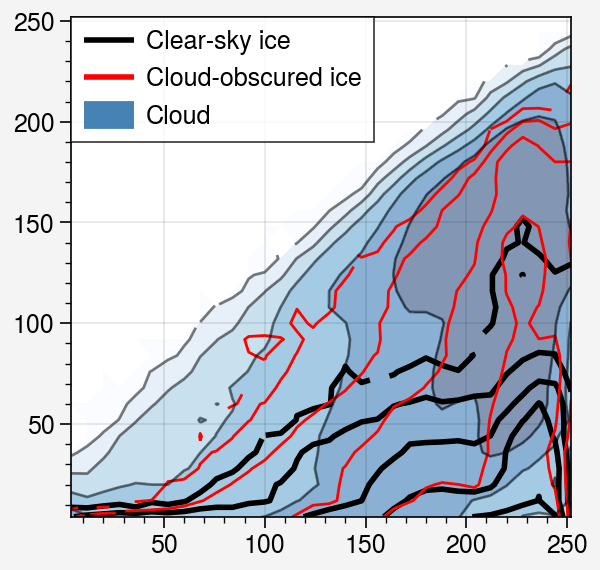

In [286]:
fig, ax = pplt.subplots()
bins = np.linspace(0, 256, 33)
binc = 0.5*(bins[1:] + bins[:-1])
H, _, _ = np.histogram2d(b2_ice_nocloud, b7_ice_nocloud, bins=[bins, bins])
H = H.T
ax.contour(binc, binc, np.log(np.ma.masked_array(H, H == 0)),
              vmin=np.log(5), vmax=10, levels=5, lw=2,
              c='k')


H, _, _ = np.histogram2d(b2_ice_cloud, b7_ice_cloud, bins=[bins, bins])
H = H.T
ax.contour(binc, binc, np.log(np.ma.masked_array(H, H == 0)),
              vmin=np.log(5), vmax=10, levels=5, lw=1,
              c='r')

H, _, _ = np.histogram2d(b2_cloud, b7_cloud, bins=[bins, bins])
H = H.T
ax.contourf(binc, binc, np.log(np.ma.masked_array(H, H == 0)),
              vmin=np.log(5), vmax=10, levels=5, lw=1,
              cmap='blues', extend='both', alpha=0.5)

h = [ax.plot([],[],ls='-', c='k', lw=2),
     ax.plot([],[],ls='-', c='r', lw=2),
     ax.plot([],[],ls='-', c='steelblue', lw=10)]
ax.legend(h, ['Clear-sky ice', 'Cloud-obscured ice', 'Cloud'], ncols=1, loc='ul')
 

# Strategies to estimate the parameters for the cloud mask
What defines a good set of parameters?
1. Pixels known to have sea ice are not masked.
2. As many cloudy pixels are masked as possible.
3. If possible without strongly degrading the cloud mask, allow cloud-covered sea ice pixels to be unmasked.

Method one: quantile-based
1. Use the clear sky sea ice pixels as a reference.
2. Specify a Band 2 threshold.
3. Set the ratio threshold = 99th percentile of B7/B2 for the pixels with B2 <= threshold
4. Set the band 7 threshold as the 99th percentile for the set of pixels with B2 > threshold. If below the ratio * B2, set to ratio * B2.

Method two: 
1. Use the clear sky sea ice pixels as a reference.
2. Specify a Band 2 threshold.
3. Calculate the B7/B2 ratio threshold based on 1.5 $\times$ IQR for pixels with B2 < threshold.
4. Calculate B7 threshold based on 1.5 $\times$ IQR for pixels with B2 > threshold. If below ratio * B2, set to ratio * B2.

Method three:
1. Specify a Band 2 threshold.
2. Find the value of the ratio that solves a max-min for covering as much of the cloud as possible with as little of the ice as possible.


In [439]:
tau_b2 = 200
get_thresholds(tau_b2, b2_ice_nocloud, b7_ice_nocloud, method='quantile')

(60.0, 0.34)

In [440]:
get_thresholds(tau_b2, b2_ice_nocloud, b7_ice_nocloud, method='iqr_outlier')

(array([32.5]), array([0.16]))

In [381]:
# Range for the b2_ice_nocloud case:
# Less than 1% of the ice data has b2 less than 118 or greater than 246
# 95% of the data is between 162 and 242. 
np.quantile(b2_ice_nocloud, [0.005, 0.995])
np.quantile(b2_ice_nocloud, [0.025, 0.975])

array([162., 242.])

In [241]:
candidate_b2 = np.arange(150, 250, 5)
nocloud_results = []
for tau_b2 in candidate_b2:
    tau_b7, tau_b7b2 = get_thresholds(tau_b2, b2_ice_nocloud, b7_ice_nocloud, method='quantile')
    tau_init, tau_b2, tau_b7, tau_b7b2

    cloud_err = compute_error(tau_init, tau_b2, tau_b7, tau_b7b2, b2_cloud, b7_cloud)
    ice_cloud_err = 1-compute_error(tau_init, tau_b2, tau_b7, tau_b7b2, b2_ice_cloud, b7_ice_cloud)
    ice_err = 1-compute_error(tau_init, tau_b2, tau_b7, tau_b7b2, b2_ice_nocloud, b7_ice_nocloud)
    nocloud_results.append([tau_b2, tau_b7, tau_b7b2, cloud_err, ice_cloud_err, ice_err])
nocloud_results = pd.DataFrame(nocloud_results, columns=['tau_b2', 'tau_b7', 'tau_b7b2', 'cloud_err', 'ice_cloud_err', 'ice_err'])

candidate_b2 = np.arange(150, 250, 5)
icecloud_results = []
for tau_b2 in candidate_b2:
    tau_b7, tau_b7b2 = get_thresholds(tau_b2, b2_ice_cloud, b7_ice_cloud,  method='quantile')


    cloud_err = compute_error(tau_init, tau_b2, tau_b7, tau_b7b2, b2_cloud, b7_cloud)
    ice_cloud_err = 1-compute_error(tau_init, tau_b2, tau_b7, tau_b7b2, b2_ice_cloud, b7_ice_cloud)
    ice_err = 1-compute_error(tau_init, tau_b2, tau_b7, tau_b7b2, b2_ice_nocloud, b7_ice_nocloud)
    icecloud_results.append([tau_b2, tau_b7, tau_b7b2, cloud_err, ice_cloud_err, ice_err])
icecloud_results = pd.DataFrame(icecloud_results, columns=['tau_b2', 'tau_b7', 'tau_b7b2', 'cloud_err', 'ice_cloud_err', 'ice_err'])

/var/folders/_1/dv6d0pjn20bgy9ysl0pfsbr40000gn/T/ipykernel_89780/846227970.py:39: RuntimeWarning: divide by zero encountered in divide
  idx = idx & (b7_data / b2_data > tau_b7b2)
/var/folders/_1/dv6d0pjn20bgy9ysl0pfsbr40000gn/T/ipykernel_89780/846227970.py:39: RuntimeWarning: invalid value encountered in divide
  idx = idx & (b7_data / b2_data > tau_b7b2)


In [242]:
nocloud_results['cross_below_ratio'] = nocloud_results['tau_b7']/nocloud_results['tau_b2'] < nocloud_results['tau_b7b2']
icecloud_results['cross_below_ratio'] = icecloud_results['tau_b7']/icecloud_results['tau_b2'] < icecloud_results['tau_b7b2']

In [243]:
nocloud_results

tau_b2  tau_b7  tau_b7b2  cloud_err  ice_cloud_err   ice_err  \
0      150  118.50      0.79   0.818840       0.011450  0.000073   
1      155  110.05      0.71   0.591114       0.093937  0.000133   
2      160  100.80      0.63   0.448543       0.202969  0.000360   
3      165   89.10      0.54   0.324774       0.315435  0.000768   
4      170   81.60      0.48   0.250044       0.376256  0.001305   
5      175   77.00      0.44   0.213756       0.411078  0.001813   
6      180   75.60      0.42   0.198923       0.428571  0.002173   
7      185   74.00      0.40   0.184679       0.446121  0.002621   
8      190   76.00      0.40   0.184679       0.446121  0.002621   
9      195   76.05      0.39   0.177105       0.455842  0.002875   
10     200   78.00      0.39   0.177105       0.455842  0.002875   
11     205   79.95      0.39   0.177105       0.455842  0.002875   
12     210   81.90      0.39   0.177105       0.455842  0.002875   
13     215   83.85      0.39   0.177105       0.455842  0.002875   
14     220   85.80      0.39   0.177105       0.455842  0.002875   
15     225   87.75      0.39   0.177105       0.455842  0.002875   
16     230   85.10      0.37   0.162455       0.475849  0.003486   
17     235   84.60      0.36   0.155147       0.486159  0.003894   
18     240   84.00      0.33   0.133347       0.517237  0.005240   
19     245  121.00      0.33   0.137228       0.505993  0.004941   

    cross_below_ratio  
0               False  
1               False  
2               False  
3               False  
4               False  
5               False  
6               False  
7               False  
8               False  
9                True  
10              False  
11              False  
12              False  
13              False  
14              False  
15              False  
16              False  
17              False  
18              False  
19              False

In [244]:
compute_error(110, 200, 190, 0.75, b2_cloud, b7_cloud)

/var/folders/_1/dv6d0pjn20bgy9ysl0pfsbr40000gn/T/ipykernel_89780/846227970.py:39: RuntimeWarning: divide by zero encountered in divide
  idx = idx & (b7_data / b2_data > tau_b7b2)
/var/folders/_1/dv6d0pjn20bgy9ysl0pfsbr40000gn/T/ipykernel_89780/846227970.py:39: RuntimeWarning: invalid value encountered in divide
  idx = idx & (b7_data / b2_data > tau_b7b2)


0.8978048078271517

In [245]:
1 - compute_error(110, 200, 190, 0.75, b2_ice_nocloud, b7_ice_nocloud)

/var/folders/_1/dv6d0pjn20bgy9ysl0pfsbr40000gn/T/ipykernel_89780/846227970.py:39: RuntimeWarning: divide by zero encountered in divide
  idx = idx & (b7_data / b2_data > tau_b7b2)
/var/folders/_1/dv6d0pjn20bgy9ysl0pfsbr40000gn/T/ipykernel_89780/846227970.py:39: RuntimeWarning: invalid value encountered in divide
  idx = idx & (b7_data / b2_data > tau_b7b2)


2.6159178601825595e-05

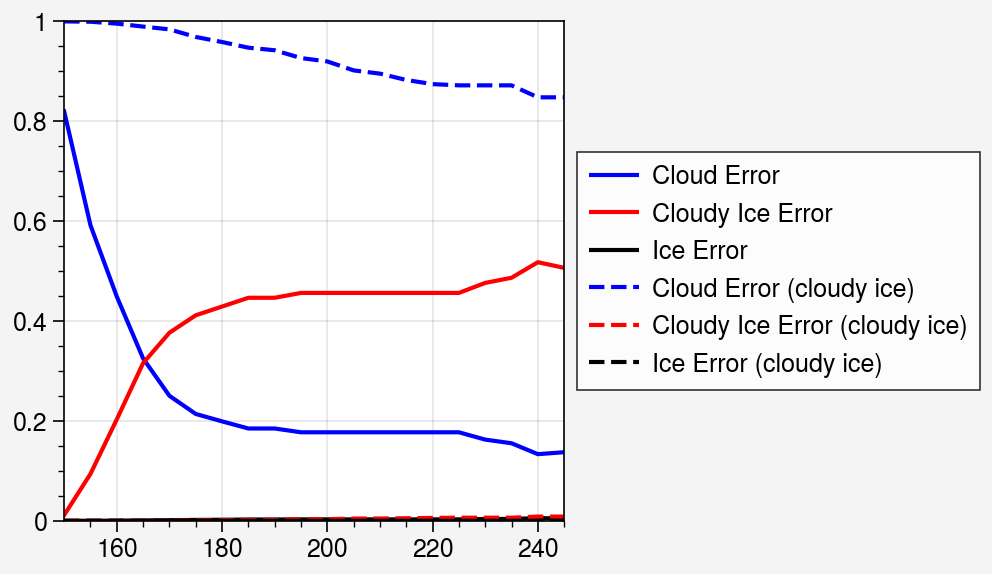

In [246]:
fig, ax = pplt.subplots()
ax.plot(nocloud_results['tau_b2'].values,
        nocloud_results['cloud_err'].values, label='Cloud Error', c='b')
ax.plot(nocloud_results['tau_b2'].values, nocloud_results['ice_cloud_err'].values,
        label='Cloudy Ice Error', c='r')
ax.plot(nocloud_results['tau_b2'].values, nocloud_results['ice_err'].values,
        label='Ice Error', c='k')

ax.plot(icecloud_results['tau_b2'].values, icecloud_results['cloud_err'].values,
        label='Cloud Error (cloudy ice)', c='b', ls='--')
ax.plot(icecloud_results['tau_b2'].values, icecloud_results['ice_cloud_err'].values,
        label='Cloudy Ice Error (cloudy ice)', c='r', ls='--')
ax.plot(icecloud_results['tau_b2'].values, icecloud_results['ice_err'].values,
        label='Ice Error (cloudy ice)', c='k', ls='--')
ax.legend(loc='r', ncols=1)
ax.format(ylim=(0, 1))

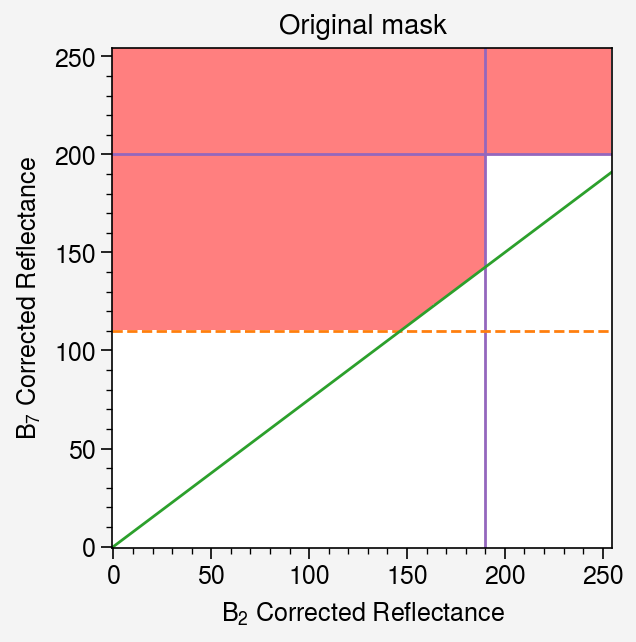

In [108]:
fig, axs = pplt.subplots(ncols=1)
# Init clouds
ax = axs[0]
X = np.zeros((255, 255))
for ii in range(255): # y axis 
    for jj in range(255): # x axis
        set1 = jj > 110
        set2 = (ii > 190) & (jj < 200)
        set3 = jj/(ii + 0.001) < 0.75
        if set1 & ~(set2 | set3):
            X[ii, jj] = 1
ax.pcolormesh(np.arange(255), np.arange(255), np.ma.masked_array(X.T, X.T==0), alpha=0.5, c='r')
ax.axvline(190, ls='-', lw=1, color='tab:purple')
ax.axhline(200, ls='-', label='B2 < tau_2', lw=1, color='tab:purple')
ax.axhline(110, ls='--', label='B7 > tau_0', lw=1, color='tab:orange')
ax.plot([0, 255], [0, 0.75*255], color='tab:green', lw=1)
ax.format(title='Original mask', ylabel='B$_7$ Corrected Reflectance', xlabel='B$_2$ Corrected Reflectance')
fig.save('../figures/init_mask_schematic.png', dpi=300)

In [248]:
tau_b7, tau_b7b2 = get_thresholds(tau_b2, b2_ice_nocloud, b7_ice_nocloud,  method='quantile')


160 100.8 0.63


/var/folders/_1/dv6d0pjn20bgy9ysl0pfsbr40000gn/T/ipykernel_89780/1810671572.py:37: RuntimeWarning: divide by zero encountered in log
  ax.contour(binc, binc, np.log(np.ma.masked_array(H, H == 0)),
/var/folders/_1/dv6d0pjn20bgy9ysl0pfsbr40000gn/T/ipykernel_89780/1810671572.py:44: RuntimeWarning: divide by zero encountered in log
  ax.contour(binc, binc, np.log(np.ma.masked_array(H, H == 0)),


<a list of 1 Line2D objects>

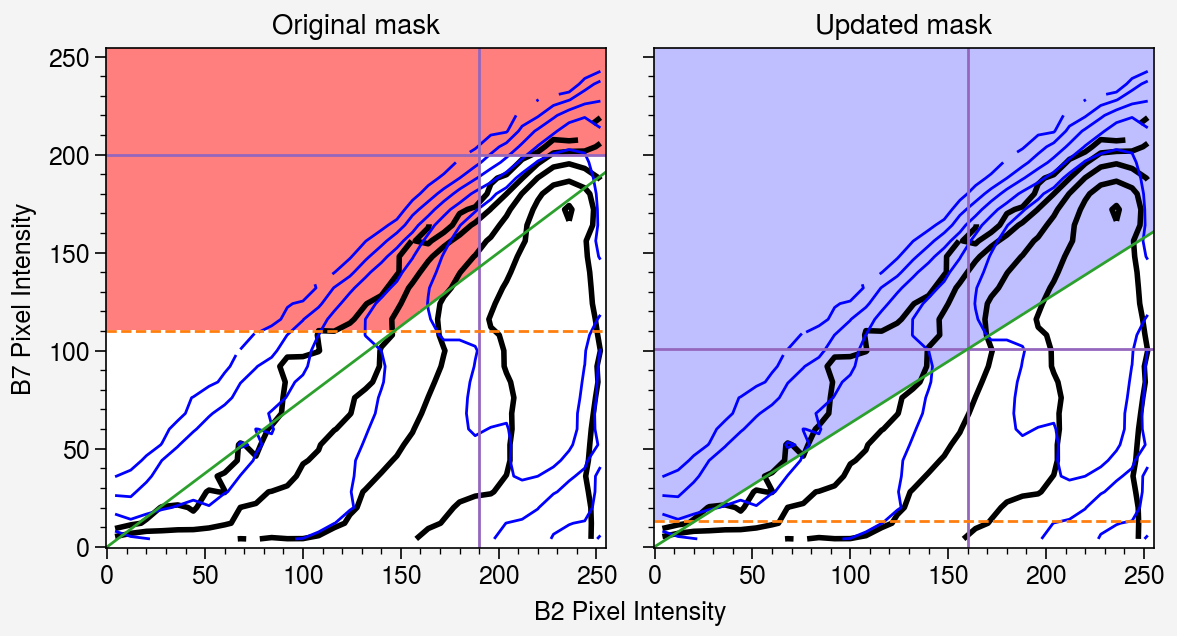

In [249]:
fig, axs = pplt.subplots(ncols=2)
# Init clouds
ax = axs[0]
X = np.zeros((255, 255))
for ii in range(255): # y axis 
    for jj in range(255): # x axis
        set1 = jj > 110
        set2 = (ii > 190) & (jj < 200)
        set3 = jj/(ii + 0.001) < 0.75
        if set1 & ~(set2 | set3):
            X[ii, jj] = 1
ax.pcolormesh(np.arange(255), np.arange(255), np.ma.masked_array(X.T, X.T==0), alpha=0.5, c='r')
ax.axvline(190, ls='-', lw=1, color='tab:purple')
ax.axhline(200, ls='-', label='B2 < tau_2', lw=1, color='tab:purple')
ax.axhline(110, ls='--', label='B7 > tau_0', lw=1, color='tab:orange')
ax.plot([0, 255], [0, 0.75*255], color='tab:green', lw=1)
ax.format(title='Original mask', ylabel='B7 Pixel Intensity', xlabel='B2 Pixel Intensity')

ax = axs[1]
tau_b2 = 160
tau_b7, tau_b7b2 = get_thresholds(tau_b2, b2_ice_nocloud, b7_ice_nocloud,  method='quantile')
print(tau_b2, tau_b7, tau_b7b2)
X = np.zeros((255, 255))
for ii in range(255): # y axis 
    for jj in range(255): # x axis
        set1 = jj > tau_init
        set2 = (ii > tau_b2) & (jj < tau_b7)
        set3 = jj/(ii + 0.001) < tau_b7b2
        if set1 & ~(set2 | set3):
            X[ii, jj] = 1

bins = np.linspace(0, 256, 33)
binc = 0.5*(bins[1:] + bins[:-1])
H, _, _ = np.histogram2d(b2_ice_cloud, b7_ice_cloud, bins=[bins, bins])
H = H.T
for ax in axs:
    ax.contour(binc, binc, np.log(np.ma.masked_array(H, H == 0)),
              vmin=np.log(5), vmax=10, levels=5, lw=2,
              c='k')

H, _, _ = np.histogram2d(b2_cloud, b7_cloud, bins=[bins, bins])
H = H.T
for ax in axs:
    ax.contour(binc, binc, np.log(np.ma.masked_array(H, H == 0)),
              vmin=np.log(5), vmax=10, levels=5, lw=1,
              c='b')


ax.pcolormesh(np.arange(255), np.arange(255), np.ma.masked_array(X.T, X.T==0), alpha=0.25, c='b')
ax.axvline(tau_b2, ls='-', label='B7 < tau_7', lw=1, color='tab:purple')
ax.axhline(tau_b7, ls='-', label='B2 < tau_2', lw=1, color='tab:purple')
ax.axhline(tau_init, ls='--', label='B7 > tau_0', lw=1, color='tab:orange')
ax.format(title='Updated mask')
ax.plot([0, 255], [0, tau_b7b2*255], color='tab:green', lw=1)

/var/folders/_1/dv6d0pjn20bgy9ysl0pfsbr40000gn/T/ipykernel_89780/1052020875.py:6: RuntimeWarning: divide by zero encountered in log
  ax.contour(binc, binc, np.log(np.ma.masked_array(H, H == 0)),
/var/folders/_1/dv6d0pjn20bgy9ysl0pfsbr40000gn/T/ipykernel_89780/1052020875.py:13: RuntimeWarning: divide by zero encountered in log
  ax.contour(binc, binc, np.log(np.ma.masked_array(H, H == 0)),
/var/folders/_1/dv6d0pjn20bgy9ysl0pfsbr40000gn/T/ipykernel_89780/1052020875.py:19: RuntimeWarning: divide by zero encountered in log
  ax.contourf(binc, binc, np.log(np.ma.masked_array(H, H == 0)),


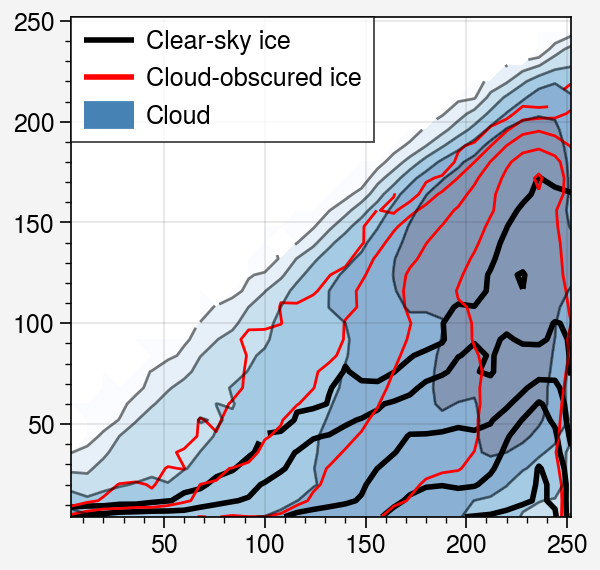

## Surprising but not hard to interpret results
1. The clear-sky sea ice pixels essentially always come through just fine
2. We get nearly as good results just using the ratio
3. We can include more cloud-covered ice by adding the bump, but that comes at a cost
4. Need to check other methods for getting the lines, perhaps based on getting the per

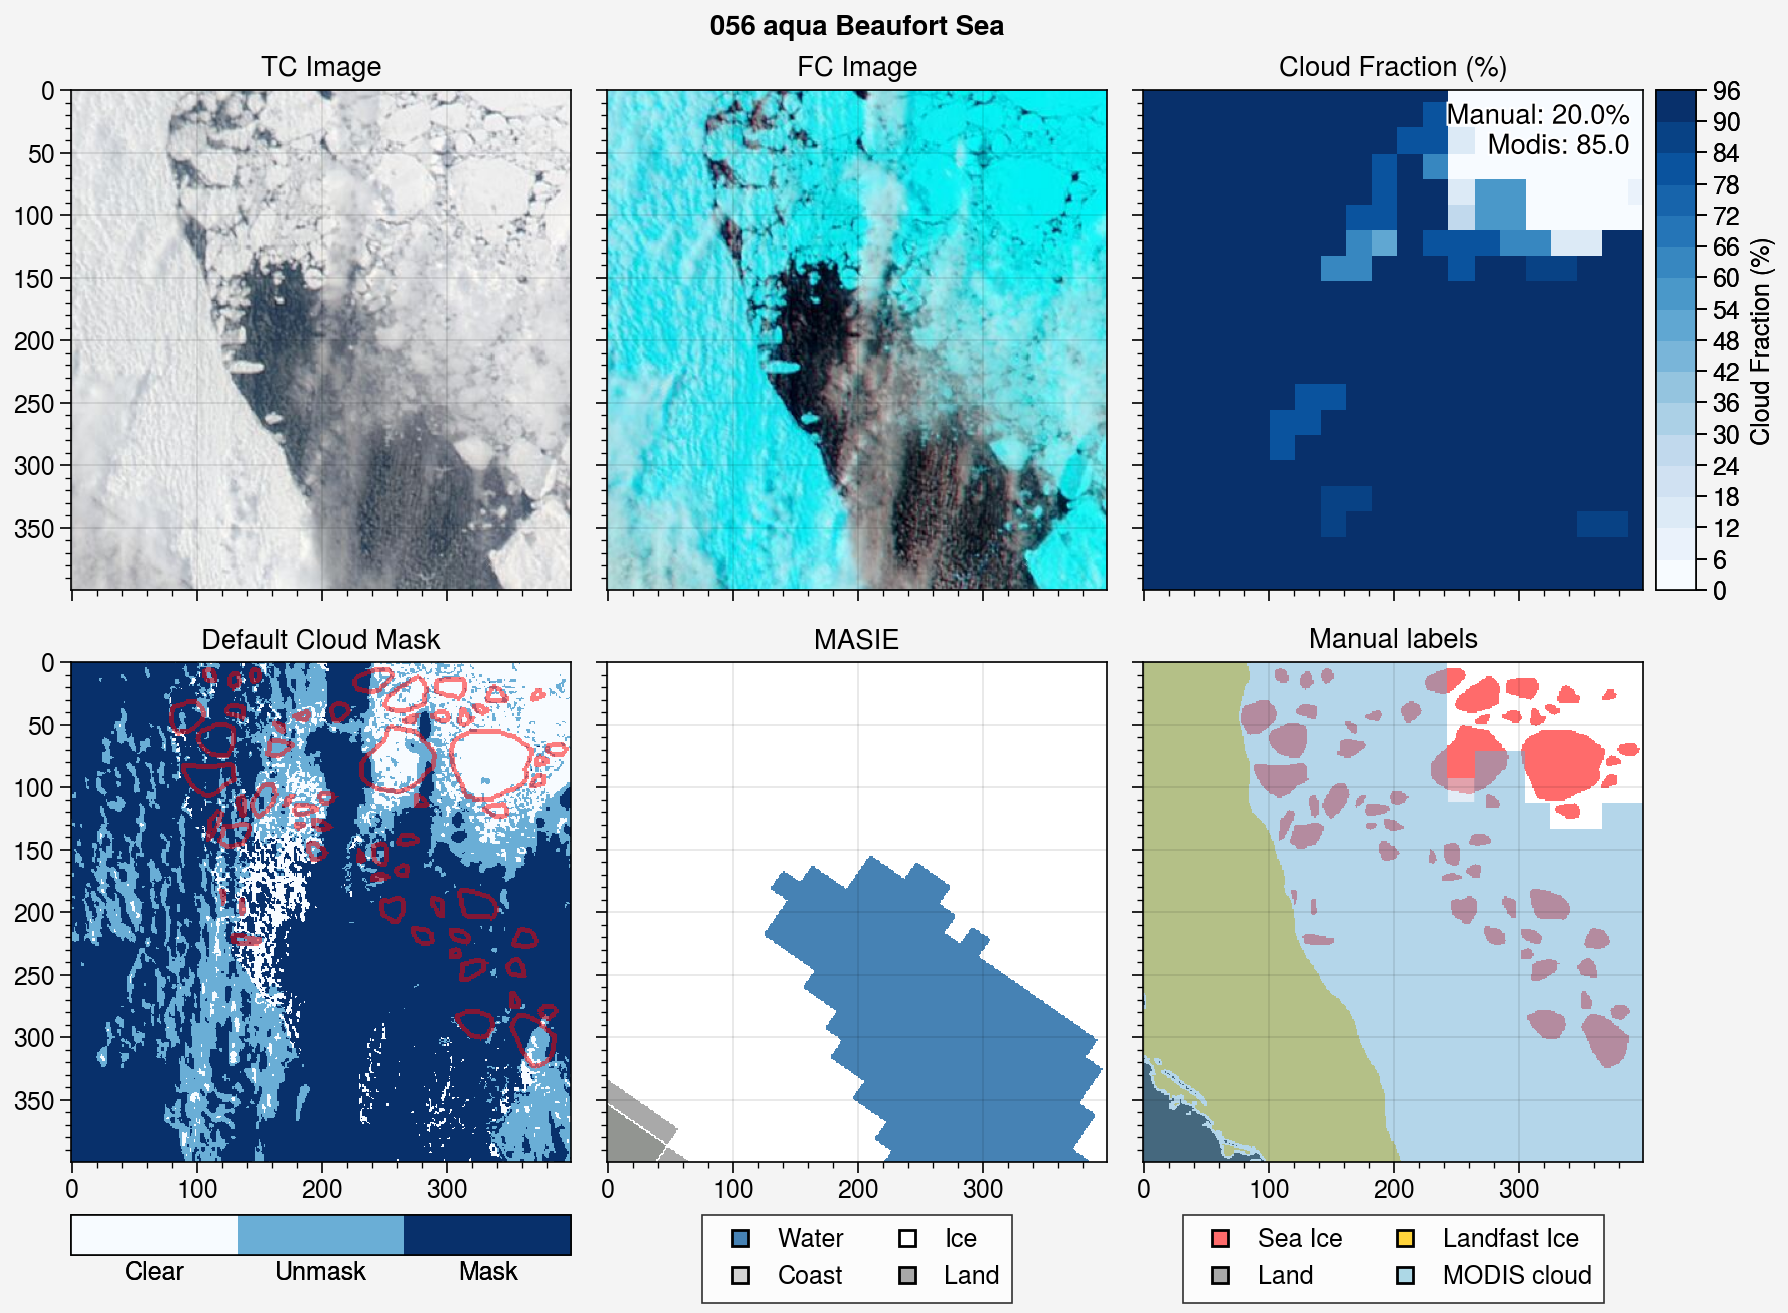

In [495]:
import skimage

case = '056_aqua'
T1 = tau_b7
T2 = tau_b2
R_upper = tau_b7b2
tc = 13

region = df.loc[case,'region']
cf_manual = (df.loc[case, 'cloud_fraction_manual']*100).round(0)
cf_modis = (df.loc[case, 'cloud_fraction_modis']*100).round(0)

fig, axs = pplt.subplots(ncols=3, nrows=2)
# first few images have a single array
clouds_view, cloud_mask = generate_masks(fc_images[case], t1=T1, t2=T2, r_lower=0, r_upper=R_upper, tc=tc)
layered_mask = ((cloud_mask).astype(float) + clouds_view.astype(float))/2
for ax, data, title in zip(axs, 
                [tc_images[case], fc_images[case], cf_images[case], layered_mask],
                ['TC Image', 'FC Image', 'Cloud Fraction (%)', 'Default Cloud Mask']):
    if title in ['TC Image', 'FC Image']:
        ax.imshow(reshape_as_image(data))
    elif title == 'Cloud Fraction (%)':
        c = ax.pcolormesh(data.values, vmin=0, vmax=100, N=17, cmap='Blues')
        ax.colorbar(c, label='Cloud Fraction (%)')
        ax.format(urtitle='Manual: {c0}%\nModis: {c1}'.format(c0=cf_manual, c1=cf_modis))
    else:
        c = ax.pcolormesh(data, N=3, cmap='blues')
        ax.colorbar(c, ticks=[.2, 0.6, 1], loc='b', alpha=1, ticklabels=['Clear', 'Unmask', 'Mask'], ticklen=0.1)
    ax.format(title=title, yreverse=True)


manual_floe_labels = lb_images[case][0,:,:] % 2
outlines = manual_floe_labels - skimage.morphology.erosion(manual_floe_labels, skimage.morphology.disk(4))
axs[1, 0].pcolormesh(np.ma.masked_array(outlines, outlines==0), color='r', alpha=0.5)



# plot MASIE data
ax = axs[1, 1]
masie_ice = mi_images[case].squeeze()
masie_land = ml_images[case].squeeze()
ax.imshow(np.ma.masked_array(masie_land, mask=masie_land != 1), c='steelblue')
ax.imshow(np.ma.masked_array(masie_ice, mask=masie_ice==0), c='w')
ax.imshow(np.ma.masked_array(masie_land, mask=masie_land != 2), c='gray')
ax.imshow(np.ma.masked_array(masie_land, mask=masie_land != 4), c='darkgray')
h = []
for c in ['steelblue', 'w', 'lightgray', 'darkgray']:
    h.append(ax.plot([],[],m='s', lw=0, c=c, edgecolor='k'))
ax.legend(h, ['Water', 'Ice', 'Coast', 'Land'], loc='b', ncols=2)
ax.format(title='MASIE')


# plot manual label data
ax = axs[1, 2]
binary_land = lm_images[case][0,:,:]
clouds25 = (cf_images[case] >= 25).astype(int)
clouds50 = (cf_images[case] >= 50).astype(int)
clouds = (clouds25 + clouds50)/2

ax.imshow(np.ma.masked_array(binary_land, mask=binary_land == 0), c='gray9')
if case in lb_images:
    manual_ice = lb_images[case][0,:,:]
    ax.imshow(np.ma.masked_array(manual_ice, mask=manual_ice==0), c='red5')
else:
    ax.format(ultitle='No ice mask')
    
if case in lf_images:
    manual_landfast = lf_images[case][0,:,:]
    ax.imshow(np.ma.masked_array(manual_landfast, mask=manual_landfast == 0), c='yellow4')
else:
    ax.format(urtitle='No landfast mask')

ax.imshow(np.ma.masked_array(clouds, mask=clouds==0), cmap='Blues', vmin=0, vmax=2, alpha=0.5)
    
h = []
for c in ['red5', 'yellow4', 'darkgray', 'lightblue']:
    h.append(ax.plot([],[],m='s', lw=0, c=c, edgecolor='k'))
ax.legend(h, ['Sea Ice', 'Landfast Ice', 'Land', 'MODIS cloud'], loc='b', ncols=2)
ax.format(title='Manual labels')

axs.format(yreverse=True, suptitle=case.replace('_', ' ') + ' ' + region.replace('_', ' ').title())
# fig.save('../figures/overview_images/' + case + '_' + region + '_overview.png', dpi=300)

In [295]:
print("B7 percentiles: 95, 99, 99.9%")
print("Cloud:   ", np.quantile(b7_cloud, [0.95, 0.99, 0.999]))
print("IceCld:  ", np.quantile(b7_ice_cloud, [0.95, 0.99, 0.999]))
print("IceNoCld:", np.quantile(b7_ice_nocloud, [0.95, 0.99, 0.999]))

B7 percentiles: 95, 99, 99.9%
Cloud:    [185. 197. 213.]
IceCld:   [152. 177. 192.]
IceNoCld: [43. 60. 99.]


In [292]:
print("B7 percentiles: 95, 99, 99.9%")
print("Cloud:   ", np.quantile(b2_cloud, [0.95, 0.99, 0.999]))
print("IceCld:  ", np.quantile(b2_ice_cloud, [0.95, 0.99, 0.999]))
print("IceNoCld:", np.quantile(b2_ice_nocloud, [0.95, 0.99, 0.999]))

B2 percentiles: 95, 99, 99.9%
[173. 185.]


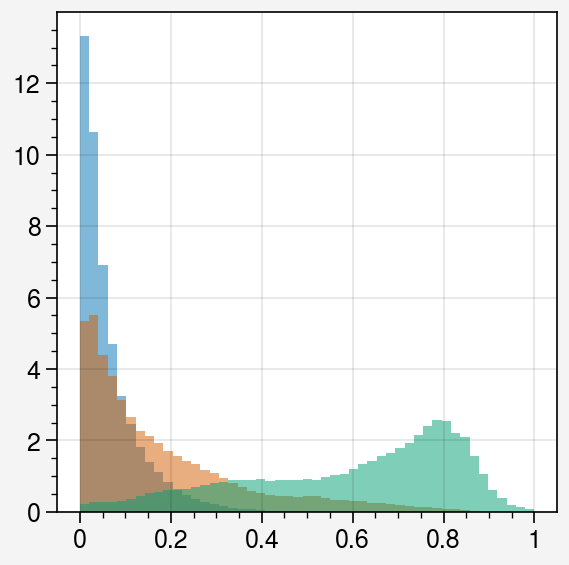

In [297]:
fig, ax = pplt.subplots()
r = b7_ice_nocloud / b2_ice_nocloud
r = r[b2_ice_nocloud < 210]
r = r[r > 0]
r = r[r < 10e5]
_ = ax.hist(r, bins=np.linspace(0, 1, 50), alpha=0.5, density=True)

r = b7_ice_cloud / b2_ice_cloud
r = r[b2_ice_cloud < 210]
r = r[r > 0]
r = r[r < 10e5]
_ = ax.hist(r, bins=np.linspace(0, 1, 50), alpha=0.5, density=True)

r = b7_cloud / b2_cloud
r = r[b2_cloud < 210]
r = r[r > 0]
r = r[r < 10e5]
_ = ax.hist(r, bins=np.linspace(0, 1, 50), alpha=0.5, density=True)

Some takeaways:
- I'll need to define a tolerance for weighing the performance with the position of each line. How much is acceptable to miss in each category?
- The cloud category has a pretty major overlap with the ice-cloud category. How can I make sure that I'm not including the cases where there are not-yet-labeled ice floes? Or clearly visible ice?
- What kind of penalty should there be for uncovering regions where no visible sea ice is there?

# Evaluating best choices for ratios
We can use the manually labeled dataset to identify thresholds and/or breakpoints. Many images are essentially 100% opaque clouds (though to be fair some of those may include sea ice with no visible floes. We'll need to select a training and testing portion of the dataset. I think the final mask should also be cleaned up so that objects smaller than, say 100 pixels, are removed from the mask. 

1. Clouds
   1. Cloud fraction > 80%
   2. Cloud type = Opaque
   3. No visible sea ice
2. Sea ice floes, clear skies
   1. Cloud fraction < 0.2
   2. Visible floes -- verify manually
   3. Compute average of estimated cloud fraction within floe
3. Sea ice floes, cloud-obscured
   1. Visible floes
   2. Cloud type thin
   3. Compte average of estimated cloud fraction within floe
4. Open water
   1. Use the MASIE ice fraction and the landmask / 

* definitely clouds
  * opaque clouds, higher than 90% cloud cover
* definitely open water
* maybe one of those but it's unclear

Ratio B7 to B2: this is the ratio of band 7 to band 1. 
- Pixels with water tend to be dark, and have higher values of the threshold.
- Pixels with snow and ice tend to have low ratios.

NSDII2: a normalized ratio of bands 4 and 2 (band 4 = 0.55, band 2 = 0.84). Band 7 is 2.1, Band 1 is 0.65, Band 3=0.46

One description of NDSI is (R1 - R2)/(R1 + R2), where R1 is visible and R2 is shortwave infrared. So in the initial modis algorithm, they'd used band 4 for R1, and used band 6 for R2, but that band is missing in Aqua. So 

Conditions 1-2: pretty good for separating ice and water, but not perfect


`


In [162]:
df.loc[(df.cloud_fraction_manual > 0.8) & (df.visible_sea_ice=='no')]

case_number             region start_date  center_lon  center_lat  \
028_aqua          028  barents_kara_seas 2018-08-19   44.060809   82.968683   
028_terra         028  barents_kara_seas 2018-08-19   44.060809   82.968683   
036_terra         036  barents_kara_seas 2020-07-01   63.838434   79.663619   
038_aqua          038  barents_kara_seas 2014-08-02   88.339718   78.769967   
038_terra         038  barents_kara_seas 2014-08-02   88.339718   78.769967   
...               ...                ...        ...         ...         ...   
174_terra         174     sea_of_okhostk 2022-05-24  140.550500   54.183539   
177_aqua          177     sea_of_okhostk 2016-03-31  144.616592   55.785542   
177_terra         177     sea_of_okhostk 2016-03-31  144.616592   55.785542   
185_aqua          185     sea_of_okhostk 2011-05-04  154.474214   58.589917   
185_terra         185     sea_of_okhostk 2011-05-04  154.474214   58.589917   

           center_x  center_y  month  sea_ice_fraction  \
028_aqua     762500    -12500      8             0.520   
028_terra    762500    -12500      8             0.520   
036_terra   1062500    362500      7             0.960   
038_aqua     887500    837500      8             1.000   
038_terra    887500    837500      8             1.000   
...             ...       ...    ...               ...   
174_terra   -387500   3987500      5             0.762   
177_aqua    -637500   3762500      3             1.000   
177_terra   -637500   3762500      3             1.000   
185_aqua   -1162500   3287500      5             0.625   
185_terra  -1162500   3287500      5             0.625   

           mean_sea_ice_concentration  ...  cloud_fraction_manual  \
028_aqua                        0.734  ...                    1.0   
028_terra                       0.734  ...                    1.0   
036_terra                       0.848  ...                    1.0   
038_aqua                        0.752  ...                    1.0   
038_terra                       0.752  ...                    1.0   
...                               ...  ...                    ...   
174_terra                       0.522  ...                    1.0   
177_aqua                        0.725  ...                    1.0   
177_terra                       0.725  ...                    1.0   
185_aqua                        0.383  ...                    1.0   
185_terra                       0.383  ...                    1.0   

          cloud_category_manual artifacts qa_analyst qa_reviewer  fl_analyst  \
028_aqua                 opaque       yes     daniel       minki         NaN   
028_terra                opaque        no     daniel       minki         NaN   
036_terra                opaque        no     daniel       ethan        emma   
038_aqua                 opaque        no     daniel       minki         NaN   
038_terra                opaque        no     daniel       minki         NaN   
...                         ...       ...        ...         ...         ...   
174_terra                opaque       yes       emma       ellen         NaN   
177_aqua                 opaque        no       emma       ellen         NaN   
177_terra                opaque       yes       emma       ellen         NaN   
185_aqua                 opaque        no     daniel       minki         NaN   
185_terra                opaque        no     daniel       minki         NaN   

          fl_reviewer psd_file                               notes  \
028_aqua          NaN      NaN                                 NaN   
028_terra         NaN      NaN                                 NaN   
036_terra      daniel      yes  dw: redrew due to missing psd file   
038_aqua          NaN      NaN                                 NaN   
038_terra         NaN      NaN                                 NaN   
...               ...      ...                                 ...   
174_terra         NaN      NaN                                 NaN   
177_aqua      

/var/folders/dc/61xkz8s134xgs5c2fmqrjgrr0000gn/T/ipykernel_21557/2340792646.py:7: RuntimeWarning: divide by zero encountered in divide
  nsdii2 = (b4 - b2)/(b4 + b2)
/var/folders/dc/61xkz8s134xgs5c2fmqrjgrr0000gn/T/ipykernel_21557/2340792646.py:8: RuntimeWarning: divide by zero encountered in divide
  mask_ratio = b7/b2
/var/folders/dc/61xkz8s134xgs5c2fmqrjgrr0000gn/T/ipykernel_21557/2340792646.py:8: RuntimeWarning: invalid value encountered in divide
  mask_ratio = b7/b2
/var/folders/dc/61xkz8s134xgs5c2fmqrjgrr0000gn/T/ipykernel_21557/2340792646.py:18: RuntimeWarning: divide by zero encountered in divide
  nsdi = (b2 - b7)/(b2 + b7) # alternative from VIIRS paper
/var/folders/dc/61xkz8s134xgs5c2fmqrjgrr0000gn/T/ipykernel_21557/2340792646.py:18: RuntimeWarning: invalid value encountered in divide
  nsdi = (b2 - b7)/(b2 + b7) # alternative from VIIRS paper


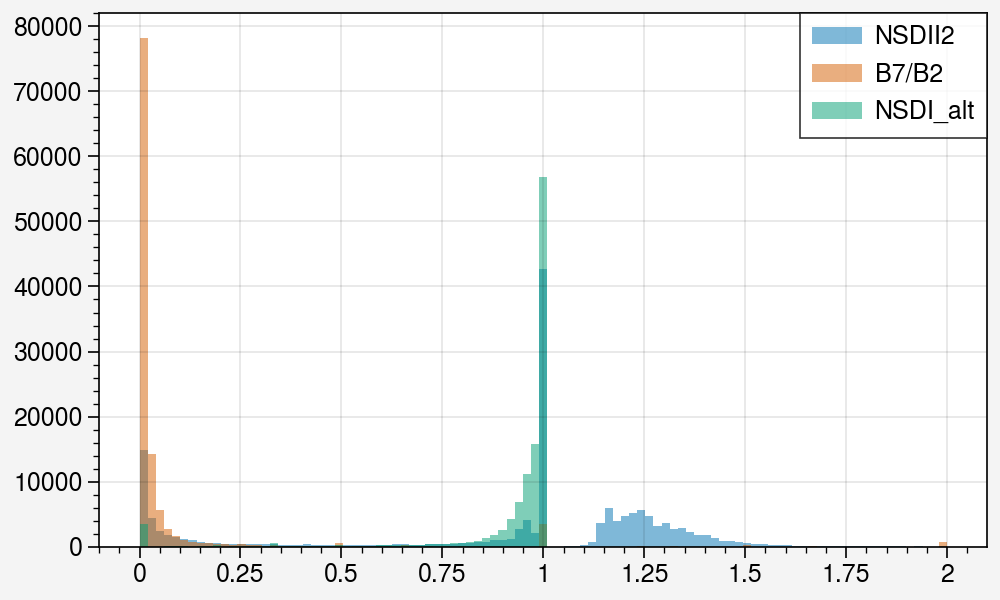

In [186]:
case = "048_aqua"
# clouds_view = fc_images[case][0,:,:] > tc # true == cloudy pixel
b4 = tc_images[case][1,:,:]
b7 = fc_images[case][0,:,:]
b2 = fc_images[case][1,:,:]

nsdii2 = (b4 - b2)/(b4 + b2)
mask_ratio = b7/b2
floes = np.ravel(lb_images[case])
nsdii2_data = np.ravel(nsdii2)
nsdii2_data = nsdii2_data[~np.isnan(nsdii2_data)]
nsdii2_data = nsdii2_data[nsdii2_data <= 2]

ratio_data = np.ravel(mask_ratio)
ratio_data = ratio_data[~np.isnan(ratio_data)]
ratio_data = ratio_data[ratio_data <= 2]

nsdi = (b2 - b7)/(b2 + b7) # alternative from VIIRS paper
nsdi_data = np.ravel(nsdi)
nsdi_data = nsdi_data[~np.isnan(nsdi_data)]
nsdi_data = nsdi_data[nsdi_data <= 2]


fig, ax = pplt.subplots(width=5, height=3)
_ = ax.hist(nsdii2_data, bins=np.linspace(0, 2, 100), alpha=0.5, label='NSDII2')
_ = ax.hist(ratio_data, bins=np.linspace(0, 2, 100), alpha=0.5, label='B7/B2')
_ = ax.hist(nsdi_data, bins=np.linspace(0, 2, 100), alpha=0.5, label='NSDI_alt')

ax.legend(ncols=1)

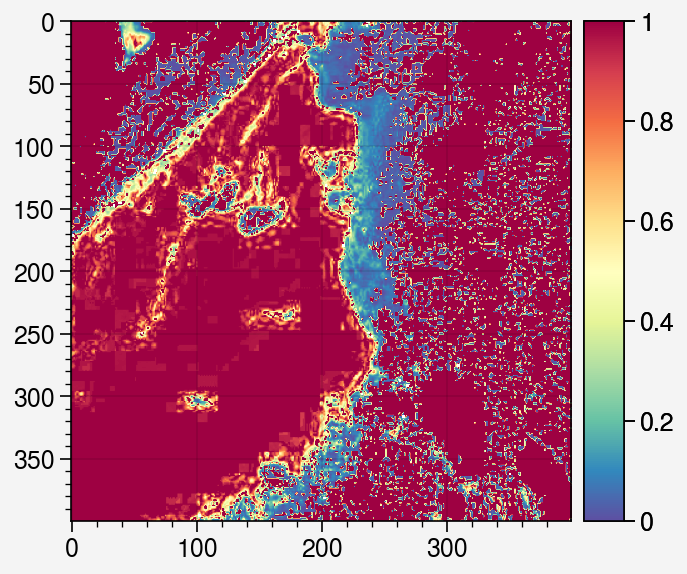

In [173]:
# 
case = "048_aqua"
# clouds_view = fc_images[case][0,:,:] > tc # true == cloudy pixel
b4 = tc_images[case][1,:,:]
b7 = fc_images[case][0,:,:]
b2 = fc_images[case][1,:,:]

nsdii2 = (b4 - b2)/(b4 + b2)
mask_ratio = b7/b2
floes = np.ravel(lb_images[case])
nsdii2_data = np.ravel(nsdii2)
nsdii2_data = nsdii2_data[~np.isnan(nsdii2_data)]
nsdii2_data = nsdii2_data[nsdii2_data <= 2]

ratio_data = np.ravel(mask_ratio)
ratio_data = ratio_data[~np.isnan(ratio_data)]
ratio_data = ratio_data[ratio_data <= 2]

fig, ax = pplt.subplots(width=5, height=3)
_ = ax.hist(nsdii2_data, bins=np.linspace(0, 2, 100), alpha=0.5, label='NSDII2')
_ = ax.hist(ratio_data, bins=np.linspace(0, 2, 100), alpha=0.5, label='B7/B2')
ax.legend(ncols=1)

/opt/homebrew/Caskroom/miniconda/base/envs/calval/lib/python3.9/site-packages/proplot/axes/cartesian.py:725: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  getattr(self, 'set_' + x + 'lim')(lim)
/opt/homebrew/Caskroom/miniconda/base/envs/calval/lib/python3.9/site-packages/proplot/axes/cartesian.py:725: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  getattr(self, 'set_' + x + 'lim')(lim)


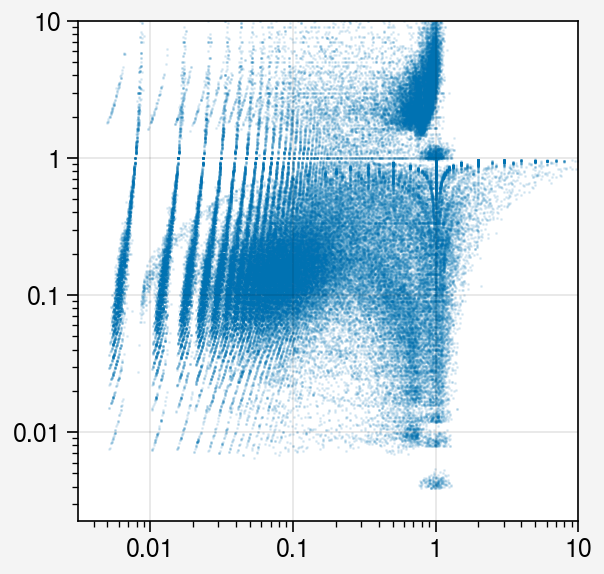

In [130]:
fig, ax = pplt.subplots()
ax.scatter(np.ravel(mask_ratio), np.ravel(nsdii2), ms=1, m='.', alpha=0.1)
ax.format(ylim=(0, 10), xlim=(0, 10), xscale='log', yscale='log')

# Alternative approach
We can look for the range of brightnesses that are observed for ice floes that are under clouds.  The thresholds should be grounded in reality in a sense at least. We can do a sweep and average across many cases, but would it be as effective? 

* We don't want a threshold so high that raising it simply increases the error in cloud cover.
* Similarly for too low.
* In between, we may want to optimize.

fc1 clear 51.0
fc1 cloudy 139.0
fc2 clear 216.0
fc2 cloudy 201.0


/var/folders/dc/61xkz8s134xgs5c2fmqrjgrr0000gn/T/ipykernel_10988/3893675673.py:52: RuntimeWarning: divide by zero encountered in divide
  brightness = np.ravel(fc_images[case][0,:,:]) / np.ravel(fc_images[case][1,:,:])
/var/folders/dc/61xkz8s134xgs5c2fmqrjgrr0000gn/T/ipykernel_10988/3893675673.py:52: RuntimeWarning: invalid value encountered in divide
  brightness = np.ravel(fc_images[case][0,:,:]) / np.ravel(fc_images[case][1,:,:])


fc1/fc2 clear 0.2542372881355932
fc1/fc2 cloudy 0.672566371681416


(array([  39513.,   10583.,   15230.,   30444.,   77451.,  187605.,
         269520.,  284221.,  277805.,  284934.,  281314.,  283564.,
         297697.,  383640.,  510575.,  508250.,  493175.,  533687.,
         579795.,  620945.,  726828.,  948219., 1266400.,  962458.,
         747087.,  399469.,  161241.,   78826.,   49729.]),
 array([0.        , 0.03448276, 0.06896552, 0.10344828, 0.13793103,
        0.17241379, 0.20689655, 0.24137931, 0.27586207, 0.31034483,
        0.34482759, 0.37931034, 0.4137931 , 0.44827586, 0.48275862,
        0.51724138, 0.55172414, 0.5862069 , 0.62068966, 0.65517241,
        0.68965517, 0.72413793, 0.75862069, 0.79310345, 0.82758621,
        0.86206897, 0.89655172, 0.93103448, 0.96551724, 1.        ]),
 <BarContainer object of 29 artists>)

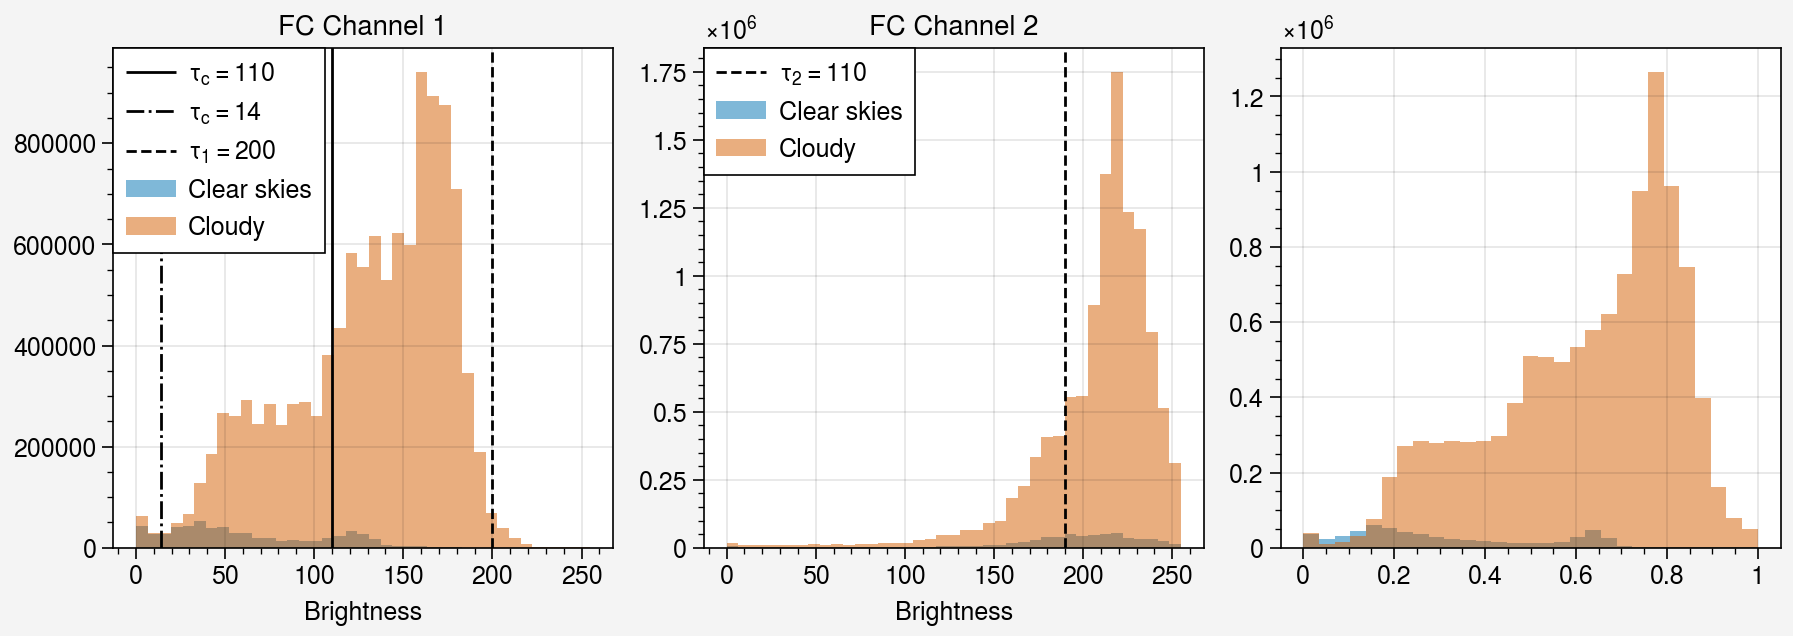

In [105]:
nearly_full_cloud_cover = df.loc[df.visible_sea_ice=='no'].index
fig, ax = pplt.subplots(ncols=3, sharex=False, sharey=False)
all_cloudy = []
all_clear = []
for case in nearly_full_cloud_cover:
    if case in cf_images:
        if fc_images[case].shape[1] == 400:
            brightness = np.ravel(fc_images[case][0,:,:])
            cloudy = np.ravel(cf_images[case]) > 80
            clear = np.ravel(cf_images[case]) <= 80
            all_cloudy.append(brightness[cloudy])
            all_clear.append(brightness[clear])
all_clear = np.hstack(all_clear)
all_cloudy = np.hstack(all_cloudy)
print('fc1', 'clear', np.median(all_clear))
print('fc1', 'cloudy', np.median(all_cloudy))
ax[0].hist(all_clear, alpha=0.5, label='Clear skies', bins=np.linspace(0, 255, 40))
ax[0].hist(all_cloudy, alpha=0.5, label='Cloudy', bins=np.linspace(0, 255, 40))
ax[0].axvline(110, label='$\\tau_c = 110$', color='k', ls='-', lw=1)
ax[0].axvline(14, label='$\\tau_c = 14$', color='k', ls='-.', lw=1)
ax[0].axvline(200, label='$\\tau_1 = 200$', color='k', ls='--', lw=1)
ax[0].format(title='FC Channel 1', xlabel='Brightness')
ax[0].legend(ncols=1, alpha=1)

all_cloudy = []
all_clear = []
for case in nearly_full_cloud_cover:
    if case in cf_images:
        if fc_images[case].shape[1] == 400:
            brightness = np.ravel(fc_images[case][1,:,:])
            cloudy = np.ravel(cf_images[case]) > 80
            clear = np.ravel(cf_images[case]) <= 80
            all_cloudy.append(brightness[cloudy])
            all_clear.append(brightness[clear])
all_cloudy = np.hstack(all_cloudy)
all_clear = np.hstack(all_clear)
print('fc2', 'clear', np.median(all_cloudy))
print('fc2', 'cloudy', np.median(all_clear))

ax[1].hist(all_clear, alpha=0.5, label='Clear skies', bins=np.linspace(0, 255, 40))
ax[1].hist(all_cloudy, alpha=0.5, label='Cloudy', bins=np.linspace(0, 255, 40))
ax[1].axvline(190, label='$\\tau_2 = 110$', color='k', ls='--', lw=1)
ax[1].format(title='FC Channel 2', xlabel='Brightness')
ax[1].legend(ncols=1, alpha=1)

all_cloudy = []
all_clear = []
for case in nearly_full_cloud_cover:
    if case in cf_images:
        if fc_images[case].shape[1] == 400:
            brightness = np.ravel(fc_images[case][0,:,:]) / np.ravel(fc_images[case][1,:,:])
            cloudy = np.ravel(cf_images[case]) > 80
            clear = np.ravel(cf_images[case]) <= 80
            all_cloudy.append(brightness[cloudy])
            all_clear.append(brightness[clear])

r = np.hstack(all_clear)
r = r[(r >= 0) & (r <= 1)]
print('fc1/fc2', 'clear', np.median(r))
ax[2].hist(r, alpha=0.5, label='Clear skies', bins=np.linspace(0, 1, 30))

r = np.hstack(all_cloudy)
r = r[(r >= 0) & (r <= 1)]
print('fc1/fc2', 'cloudy', np.median(r))
ax[2].hist(r, alpha=0.5, label='Clear skies', bins=np.linspace(0, 1, 30))


In [ ]:
fig, ax = pplt.subplots(ncols=3, sharex=False, sharey=False)
sea_ice_cloudy = []
sea_ice_clear = []
for case in lb_images:
    if lb_images[case].shape[1] == 400:
        brightness = np.ravel(fc_images[case][0,:,:])
        cloudy = np.ravel(cf_images[case]) > 80
        sea_ice = np.ravel(lb_images[case][0,:,:]) > 0
        sea_ice_cloudy.append(brightness[cloudy & sea_ice])
        sea_ice_clear.append(brightness[~cloudy & sea_ice])
sea_ice_clear = np.hstack(sea_ice_clear)
sea_ice_cloudy = np.hstack(sea_ice_cloudy)
print('fc1', 'clear', np.median(sea_ice_clear))
print('fc1', 'cloudy', np.median(sea_ice_cloudy))
ax[0].hist(np.hstack(sea_ice_clear), alpha=0.5, label='Clear skies', bins=np.linspace(0, 255, 40))
ax[0].hist(np.hstack(sea_ice_cloudy), alpha=0.5, label='Cloudy', bins=np.linspace(0, 255, 40))
ax[0].axvline(110, label='$\\tau_c = 110$', color='k', ls='-', lw=1)
ax[0].axvline(14, label='$\\tau_c = 14$', color='k', ls='-.', lw=1)
ax[0].axvline(200, label='$\\tau_1 = 200$', color='k', ls='--', lw=1)
ax[0].format(title='FC Channel 1', xlabel='Brightness')
ax[0].legend(ncols=1, alpha=1)

sea_ice_cloudy = []
sea_ice_clear = []
for case in lb_images:
    if lb_images[case].shape[1] == 400:
        brightness = np.ravel(fc_images[case][1,:,:])
        cloudy = np.ravel(cf_images[case]) > 80
        sea_ice = np.ravel(lb_images[case][0,:,:]) > 0
        sea_ice_cloudy.append(brightness[cloudy & sea_ice])
        sea_ice_clear.append(brightness[~cloudy & sea_ice])
sea_ice_clear = np.hstack(sea_ice_clear)
sea_ice_cloudy = np.hstack(sea_ice_cloudy)
print('fc2', 'clear', np.median(sea_ice_clear))
print('fc2', 'cloudy', np.median(sea_ice_cloudy))

ax[1].hist(np.hstack(sea_ice_clear), alpha=0.5, label='Clear skies', bins=np.linspace(0, 255, 40))
ax[1].hist(np.hstack(sea_ice_cloudy), alpha=0.5, label='Cloudy', bins=np.linspace(0, 255, 40))
ax[1].axvline(190, label='$\\tau_2 = 110$', color='k', ls='--', lw=1)
ax[1].format(title='FC Channel 2', xlabel='Brightness')
ax[1].legend(ncols=1, alpha=1)

sea_ice_cloudy = []
sea_ice_clear = []
for case in lb_images:
    if lb_images[case].shape[1] == 400:
        brightness = np.ravel(fc_images[case][0,:,:]) / np.ravel(fc_images[case][1,:,:])
        cloudy = np.ravel(cf_images[case]) > 80
        sea_ice = np.ravel(lb_images[case][0,:,:]) > 0
        sea_ice_cloudy.append(brightness[cloudy & sea_ice])
        sea_ice_clear.append(brightness[~cloudy & sea_ice])

r = np.hstack(sea_ice_clear)
r = r[(r >= 0) & (r <= 1)]
print('fc1/fc2', 'clear', np.median(r))
ax[2].hist(r, alpha=0.5, label='Clear skies', bins=np.linspace(0, 1, 30))

r = np.hstack(sea_ice_cloudy)
r = r[(r >= 0) & (r <= 1)]
print('fc1/fc2', 'cloudy', np.median(r))

ax[2].hist(r, alpha=0.5, label='Cloudy', bins=np.linspace(0, 1, 30))
ax[2].axvline(0.75, label='$\\tau_r = 0.75$', color='k', ls='-', lw=1)
ax[2].format(title='FC Channel 1-2 Ratio', xlabel='Brightness', xlim=(0, 1))
ax[2].legend(ncols=1, alpha=1)
fig.save('../figures/false_color_histograms.png', dpi=300)


We divided the ground truth sea ice floe data into cloudy and clear pixels based on a threshold of 80% cloud cover. What we can see is that the original $\tau_c = 100$ ensured no clear-sky sea ice floes were covered by the first step of the cloud mask algorithm. With the stricter setting of $\tau_c = 14$, a larger fraction of the ice would be initially considered cloud-covered.

$\tau_1$ sets an upper bound for the brightness of sea ice under clouds in channel 1, while the threshold $\tau_2$ on channel 2 functions is a lower bound for how bright Channel 2 needs to be to count as ice. Finally, the brightness ratio is considered. We see that ice under clear skies has a markedly different ratio: under clear skies, most ice has low ratios (under 0.2), while under clouds, the ratios can be up to 0.85.

We test the following ranges:
* $\tau_1$ from 50 to 200
* $\tau_2$ from 100 to 250
* $\tau_r$ from 0 to 0.9




# Applying the min-max operation to a larger set of images

Thinking of the right approach here. It might be better to use a histogram method for the choices of T1 and T2, then to optimize over the possible values of R. The weighting is going to be important and I'm sure there's a variety of ways that the difference in floe numbers across images could be an issue.


In [106]:
labeled_cases = []
for case in lb_images:
    if lb_images[case].shape[1] == 400:
        labeled_cases.append(case)
        
df_training = df.loc[labeled_cases].sample(frac=2/3, replace=False, random_state=306)
df_testing = df.loc[labeled_cases].loc[[x for x in labeled_cases if x not in df_training.index]]

In [113]:
%%time
tc = 14

r_upper = 0.75 # 0 = Only using t1 and t2
example_results = []
for case in df_training.index:
    if (case in fc_images) & (case in lb_images):
        for t1 in range(50, 205, 5):
            for t2 in range(100, 255, 5):
                clouds_view, cloud_mask = generate_masks(fc_images[case], t1=t1, t2=t2, r_lower=0, r_upper=r_upper, tc=tc)
                manual_floe_labels = lb_images[case][0,:,:]
            
                delta_cf = cloud_fraction_loss_function(cloud_mask, clouds_view)
                delta_si = sea_ice_fraction_loss_function(cloud_mask, manual_floe_labels)
                mean_error = (clouds_view & (manual_floe_labels == 0)) != cloud_mask
                example_results.append([case, tc, t1, t2, r_upper, delta_cf, delta_si, np.mean(mean_error), np.mean(clouds_view)])
example_results = pd.DataFrame(example_results, columns=['case', 'tc', 't_1', 't_2', 'ratio', 'delta_cf', 'delta_si', 'mean_error', 'cloud_fraction'])

/var/folders/dc/61xkz8s134xgs5c2fmqrjgrr0000gn/T/ipykernel_10988/1523296688.py:6: RuntimeWarning: invalid value encountered in divide
  mask_ratio = fc_image[0,:,:]/fc_image[1,:,:]
/var/folders/dc/61xkz8s134xgs5c2fmqrjgrr0000gn/T/ipykernel_10988/1523296688.py:6: RuntimeWarning: divide by zero encountered in divide
  mask_ratio = fc_image[0,:,:]/fc_image[1,:,:]


CPU times: user 41.6 s, sys: 80.4 ms, total: 41.6 s
Wall time: 41.6 s


In [114]:
example_results['t1t2'] = [str(x) + '_' + str(y) for x, y in zip(example_results.t_1, example_results.t_2)]


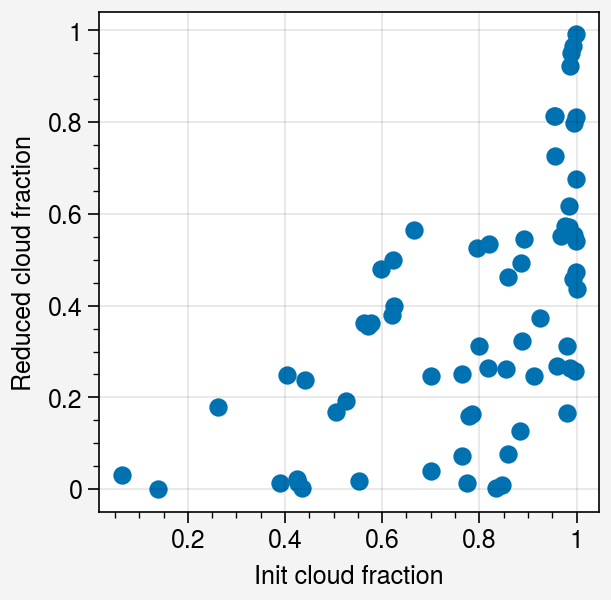

In [115]:
fig, ax = pplt.subplots()
test = example_results.loc[example_results.t1t2 == '200_190']
ax.scatter(test.cloud_fraction, test.cloud_fraction*test.delta_cf) 
ax.format(xlabel='Init cloud fraction', ylabel='Reduced cloud fraction')

In [ ]:
sea_ice_fraction_loss_function??

In [116]:
r_upper = 0.25 # 0 = Only using t1 and t2
example_results = []
for case in df_training.index:
    for t1 in range(50, 205, 5):
        for t2 in range(100, 255, 5):
            clouds_view, cloud_mask = generate_masks(fc_images[case], t1=t1, t2=t2, r_lower=0, r_upper=r_upper, tc=tc)
            manual_floe_labels = lb_images[case][0,:,:]
        
            delta_cf = cloud_fraction_loss_function(cloud_mask, clouds_view)
            delta_si = sea_ice_fraction_loss_function(cloud_mask, manual_floe_labels)
            mean_error = (clouds_view & (manual_floe_labels == 0)) != cloud_mask
            example_results.append([case, tc, t1, t2, r_upper, delta_cf, delta_si, np.mean(mean_error)])
example_results_r25 = pd.DataFrame(example_results, columns=['case', 'tc', 't_1', 't_2', 'ratio', 'delta_cf', 'delta_si', 'mean_error'])

/var/folders/dc/61xkz8s134xgs5c2fmqrjgrr0000gn/T/ipykernel_10988/1523296688.py:6: RuntimeWarning: invalid value encountered in divide
  mask_ratio = fc_image[0,:,:]/fc_image[1,:,:]
/var/folders/dc/61xkz8s134xgs5c2fmqrjgrr0000gn/T/ipykernel_10988/1523296688.py:6: RuntimeWarning: divide by zero encountered in divide
  mask_ratio = fc_image[0,:,:]/fc_image[1,:,:]


KeyError: '100_aqua'

In [ ]:
example_results_r25['t1t2'] = [str(x) + '_' + str(y) for x, y in zip(example_results_r25.t_1, example_results_r25.t_2)]

In [ ]:
fig, axs = pplt.subplots(height=5, ncols=3, nrows=2, share=False)
data = example_results[['t_1', 't_2', 'delta_cf', 'delta_si', 'mean_error', 't1t2']].groupby('t1t2').mean()
# data = data.where(data.delta_cf <= 0.2)
for ax, var in zip(axs[0,:], ['delta_si', 'delta_cf', 'mean_error']):
    c=ax.contourf(data.pivot_table(index='t_2', columns='t_1', values=var), cmap='tokyo_r', vmin=0, vmax=1)
    ax.colorbar(c, label=var)
    ax.format(ylabel='$\\tau_2$')
    ax.format(xlabel='$\\tau_1$')

data = example_results_r25[['t_1', 't_2', 'delta_cf', 'delta_si', 'mean_error', 't1t2']].groupby('t1t2').mean()

for ax, var in zip(axs[1,:], ['delta_si', 'delta_cf', 'mean_error']):
    c=ax.contourf(data.pivot_table(index='t_2', columns='t_1', values=var), cmap='tokyo_r', vmin=0, vmax=1)
    ax.colorbar(c, label=var)
    ax.format(ylabel='$\\tau_2$')
    ax.format(xlabel='$\\tau_1$')

axs.format(leftlabels=['r=0.75', 'r=0.25'], toplabels=['Fraction sea ice uncovered', 'Reduction in cloud cover', 'Mean difference'])

Metrics for the "thin cloud identification" step. 
1. Quantify the reduction in cloud cover (what we want to minimize). Pixels where there were clouds, the clouds were removed, and no ice floe is visible. $CF_{all}$ and $CF_{thin}$ and not $SI$.
2. Quantify the increase in sea ice floe visibility. Pixels where there were clouds, the clouds were removed, and an ice floe is visible. $CF_{all}$ and $CF_{thin}$ and $SI$.

Interpretation: the pixels with ratio less than a give amount are removed from the cloud mask as likely containing sea ice. So with a high ratio, only the T1 and T2 thresholds are limiting anything. Lower ratios result in larger numbers of cloud pixels being masked.

These are not adjusted for the number of sea ice pixels.

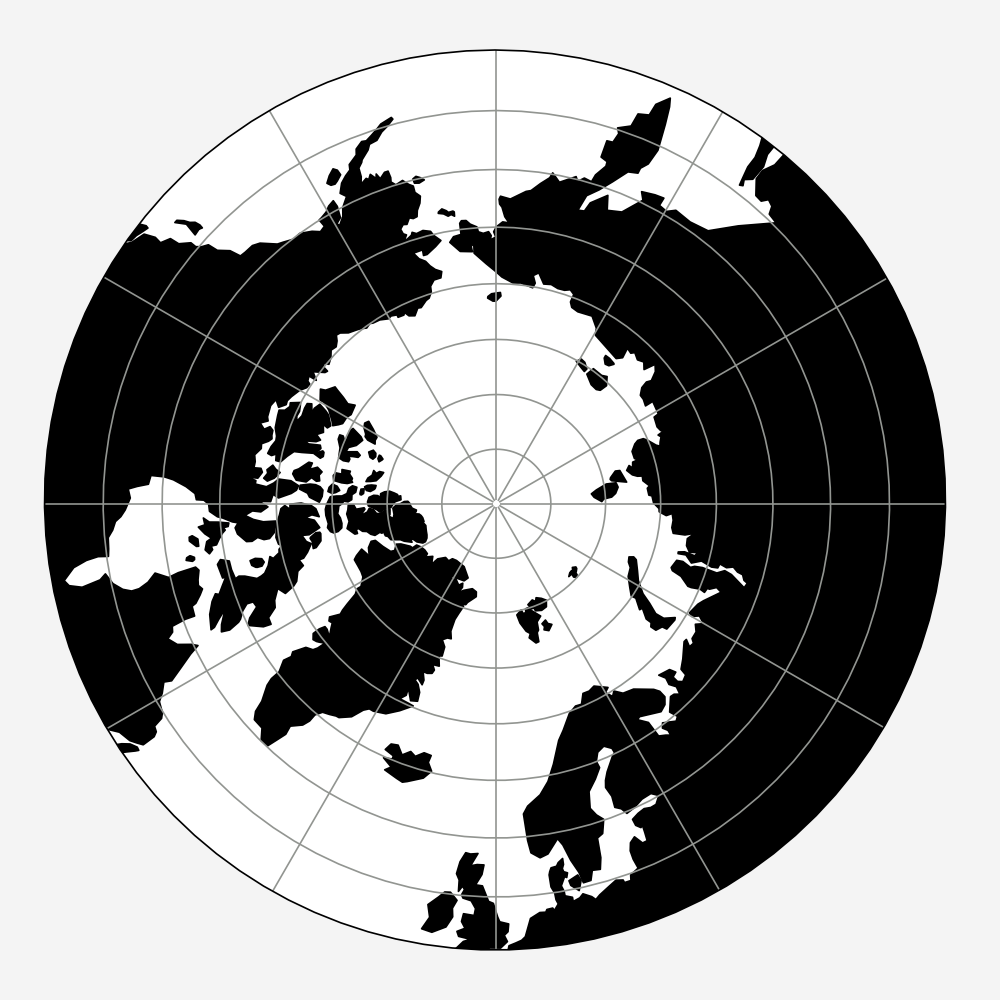

In [227]:
import matplotlib.path as mpath
import matplotlib.pyplot as plt
import numpy as np

import cartopy.crs as ccrs
import cartopy.feature as cfeature

fig = plt.figure(figsize=[5, 5])
ax = fig.add_subplot(1, 1, 1, projection=ccrs.NorthPolarStereo())

fig.subplots_adjust(bottom=0.05, top=0.95,
                    left=0.04, right=0.95, wspace=0.02)

# Limit the map to -60 degrees latitude and below.
ax.set_extent([-180, 180, 50, 90], ccrs.PlateCarree())

ax.add_feature(cfeature.LAND, color='k')


ax.gridlines(xlocs=np.arange(-180, 180, 30), color='gray')

# Compute a circle in axes coordinates, which we can use as a boundary
# for the map. We can pan/zoom as much as we like - the boundary will be
# permanently circular.
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)
ax.set_boundary(circle, transform=ax.transAxes)

# plt.show()

Signature:
ax.gridlines(
    crs=None,
    draw_labels=False,
    xlocs=None,
    ylocs=None,
    dms=False,
    x_inline=None,
    y_inline=None,
    auto_inline=True,
    xformatter=None,
    yformatter=None,
    xlim=None,
    ylim=None,
    rotate_labels=None,
    xlabel_style=None,
    ylabel_style=None,
    labels_bbox_style=None,
    xpadding=5,
    ypadding=5,
    offset_angle=25,
    auto_update=False,
    formatter_kwargs=None,
    **kwargs,
)
Docstring:
Automatically add gridlines to the axes, in the given coordinate
system, at draw time.

Parameters
----------
crs: optional
    The :class:`cartopy._crs.CRS` defining the coordinate system in
    which gridlines are drawn.
    Defaults to :class:`cartopy.crs.PlateCarree`.
draw_labels: optional
    Toggle whether to draw labels. For finer control, attributes of
    :class:`Gridliner` may be modified individually. Defaults to False.

    - string: "x" or "y" to only draw labels of the respective
      coordinate in the CRS.
   